<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-summary" data-toc-modified-id="Data-summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data summary</a></span></li><li><span><a href="#Metrics" data-toc-modified-id="Metrics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Metrics</a></span></li><li><span><a href="#Example:-Jerk-calculation-for-manual-control-data" data-toc-modified-id="Example:-Jerk-calculation-for-manual-control-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Example: Jerk calculation for manual control data</a></span></li><li><span><a href="#Example:-2021-04-24" data-toc-modified-id="Example:-2021-04-24-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Example: 2021-04-24</a></span><ul class="toc-item"><li><span><a href="#Result-loading" data-toc-modified-id="Result-loading-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Result loading</a></span></li><li><span><a href="#Crowd-related-metrics" data-toc-modified-id="Crowd-related-metrics-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Crowd-related metrics</a></span></li><li><span><a href="#Path-Efficiency-related-metrics" data-toc-modified-id="Path-Efficiency-related-metrics-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Path Efficiency-related metrics</a></span></li><li><span><a href="#Shared-control-related-metrics" data-toc-modified-id="Shared-control-related-metrics-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Shared control-related metrics</a></span></li></ul></li><li><span><a href="#Example:-2021-04-10" data-toc-modified-id="Example:-2021-04-10-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Example: 2021-04-10</a></span><ul class="toc-item"><li><span><a href="#Result-loading" data-toc-modified-id="Result-loading-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Result loading</a></span></li><li><span><a href="#Crowd-related-metrics" data-toc-modified-id="Crowd-related-metrics-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Crowd-related metrics</a></span></li><li><span><a href="#Path-Efficiency-related-metrics" data-toc-modified-id="Path-Efficiency-related-metrics-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Path Efficiency-related metrics</a></span></li><li><span><a href="#Shared-control-related-metrics" data-toc-modified-id="Shared-control-related-metrics-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Shared control-related metrics</a></span></li></ul></li><li><span><a href="#Example:-2021-12-03" data-toc-modified-id="Example:-2021-12-03-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Example: 2021-12-03</a></span><ul class="toc-item"><li><span><a href="#Results-loading" data-toc-modified-id="Results-loading-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Results loading</a></span></li><li><span><a href="#Crowd-related-metrics" data-toc-modified-id="Crowd-related-metrics-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Crowd-related metrics</a></span></li><li><span><a href="#Path-Efficiency-related-metrics" data-toc-modified-id="Path-Efficiency-related-metrics-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Path Efficiency-related metrics</a></span></li><li><span><a href="#Shared-control-related-metrics" data-toc-modified-id="Shared-control-related-metrics-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Shared control-related metrics</a></span></li></ul></li><li><span><a href="#Comparison-of-all-control-type-between-0410-and-0424" data-toc-modified-id="Comparison-of-all-control-type-between-0410-and-0424-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Comparison of all control type between 0410 and 0424</a></span><ul class="toc-item"><li><span><a href="#Result-loading" data-toc-modified-id="Result-loading-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Result loading</a></span></li><li><span><a href="#Mean-Std-statistics" data-toc-modified-id="Mean-Std-statistics-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Mean-Std statistics</a></span></li><li><span><a href="#Crowd-related-metrics" data-toc-modified-id="Crowd-related-metrics-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Crowd-related metrics</a></span></li><li><span><a href="#Path-Efficiency-related-metrics" data-toc-modified-id="Path-Efficiency-related-metrics-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Path Efficiency-related metrics</a></span></li><li><span><a href="#Shared-control-related-metrics" data-toc-modified-id="Shared-control-related-metrics-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Shared control-related metrics</a></span></li><li><span><a href="#Analysis-without-grouping-by-date" data-toc-modified-id="Analysis-without-grouping-by-date-7.6"><span class="toc-item-num">7.6&nbsp;&nbsp;</span>Analysis without grouping by date</a></span></li><li><span><a href="#ANOVA-test" data-toc-modified-id="ANOVA-test-7.7"><span class="toc-item-num">7.7&nbsp;&nbsp;</span>ANOVA test</a></span></li></ul></li><li><span><a href="#Comparison-between-shared_control-on-0325,-0410,-0424,-and-1203" data-toc-modified-id="Comparison-between-shared_control-on-0325,-0410,-0424,-and-1203-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Comparison between shared_control on 0325, 0410, 0424, and 1203</a></span><ul class="toc-item"><li><span><a href="#Result-loading" data-toc-modified-id="Result-loading-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Result loading</a></span></li><li><span><a href="#Analysis-given-different-dates" data-toc-modified-id="Analysis-given-different-dates-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Analysis given different dates</a></span><ul class="toc-item"><li><span><a href="#Mean-Std-statistics" data-toc-modified-id="Mean-Std-statistics-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>Mean-Std statistics</a></span></li><li><span><a href="#ANOVA-test" data-toc-modified-id="ANOVA-test-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>ANOVA test</a></span></li><li><span><a href="#Crowd-related-metrics" data-toc-modified-id="Crowd-related-metrics-8.2.3"><span class="toc-item-num">8.2.3&nbsp;&nbsp;</span>Crowd-related metrics</a></span></li><li><span><a href="#Path-Efficiency-related-metrics" data-toc-modified-id="Path-Efficiency-related-metrics-8.2.4"><span class="toc-item-num">8.2.4&nbsp;&nbsp;</span>Path Efficiency-related metrics</a></span></li><li><span><a href="#Shared-control-metrics" data-toc-modified-id="Shared-control-metrics-8.2.5"><span class="toc-item-num">8.2.5&nbsp;&nbsp;</span>Shared control metrics</a></span></li></ul></li><li><span><a href="#Analysis-given-cluster" data-toc-modified-id="Analysis-given-cluster-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Analysis given cluster</a></span><ul class="toc-item"><li><span><a href="#Cluster-according-to-crowd-density-metrics" data-toc-modified-id="Cluster-according-to-crowd-density-metrics-8.3.1"><span class="toc-item-num">8.3.1&nbsp;&nbsp;</span>Cluster according to crowd density metrics</a></span><ul class="toc-item"><li><span><a href="#Clustering-results-visualization-by-cluster" data-toc-modified-id="Clustering-results-visualization-by-cluster-8.3.1.1"><span class="toc-item-num">8.3.1.1&nbsp;&nbsp;</span>Clustering results visualization by cluster</a></span></li><li><span><a href="#Clustering-results-visualization-by-date" data-toc-modified-id="Clustering-results-visualization-by-date-8.3.1.2"><span class="toc-item-num">8.3.1.2&nbsp;&nbsp;</span>Clustering results visualization by date</a></span></li></ul></li><li><span><a href="#Mean-Std" data-toc-modified-id="Mean-Std-8.3.2"><span class="toc-item-num">8.3.2&nbsp;&nbsp;</span>Mean-Std</a></span></li><li><span><a href="#ANOVA-test" data-toc-modified-id="ANOVA-test-8.3.3"><span class="toc-item-num">8.3.3&nbsp;&nbsp;</span>ANOVA test</a></span></li><li><span><a href="#Crowd-related-metrics" data-toc-modified-id="Crowd-related-metrics-8.3.4"><span class="toc-item-num">8.3.4&nbsp;&nbsp;</span>Crowd-related metrics</a></span><ul class="toc-item"><li><span><a href="#Original-4-in-1-plotting" data-toc-modified-id="Original-4-in-1-plotting-8.3.4.1"><span class="toc-item-num">8.3.4.1&nbsp;&nbsp;</span>Original 4-in-1 plotting</a></span></li><li><span><a href="#Updated-plotting" data-toc-modified-id="Updated-plotting-8.3.4.2"><span class="toc-item-num">8.3.4.2&nbsp;&nbsp;</span>Updated plotting</a></span></li></ul></li><li><span><a href="#Path-Efficiency-related-metrics" data-toc-modified-id="Path-Efficiency-related-metrics-8.3.5"><span class="toc-item-num">8.3.5&nbsp;&nbsp;</span>Path Efficiency-related metrics</a></span></li><li><span><a href="#Shared-control-metrics" data-toc-modified-id="Shared-control-metrics-8.3.6"><span class="toc-item-num">8.3.6&nbsp;&nbsp;</span>Shared control metrics</a></span></li></ul></li></ul></li><li><span><a href="#one-way-ANOVA-test-with-different-control-methods" data-toc-modified-id="one-way-ANOVA-test-with-different-control-methods-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>one-way ANOVA test with different control methods</a></span><ul class="toc-item"><li><span><a href="#Mean-Std-statistics" data-toc-modified-id="Mean-Std-statistics-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Mean-Std statistics</a></span></li><li><span><a href="#ANOVA-test" data-toc-modified-id="ANOVA-test-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>ANOVA test</a></span></li></ul></li></ul></div>

# Crowd navigation evaluation

> Analysis of different control methods on different datas

In [1]:
import math
import datetime
import collections
import sys, os, fnmatch
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt

# use serif and customized style
# https://stackoverflow.com/questions/42097053/matplotlib-cannot-find-basic-fonts
# https://matplotlib.org/stable/tutorials/text/mathtext.html
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
use_serif_font = True
if use_serif_font:
    plt.style.use('./styles/serif.mplstyle')
else:
    plt.style.use('./styles/sans_serif.mplstyle')

plt.ioff()
import seaborn as sns
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 1.3})

from qolo.utils.notebook_util import walk, violinplot, categorical_plot, import_eval_res, values2colors, values2color_list
from qolo.core.crowdbot_data import CrowdBotDatabase, CrowdBotData
from qolo.metrics.metric_qolo_perf import compute_rel_jerk

In [2]:
qolo_dataset = CrowdBotData()

bagbase = qolo_dataset.bagbase_dir
outbase = qolo_dataset.outbase_dir

chosen_dates = ['0325', '0327', '0410', '0424', '1203']
chosen_type = ['mds', 'rds', 'shared_control'] # 'test', 'manual'

print("rosbag database:", bagbase)

all_bagdir = []
for dir_ in os.listdir(bagbase):
    if any(s in dir_ for s in chosen_dates) and any(s in dir_ for s in chosen_type):
        all_bagdir.append(dir_)
print(all_bagdir)

all_outdir = []
for dir_ in os.listdir(outbase):
    if '.zip' in dir_:
        continue
    if any(s in dir_ for s in chosen_dates) and any(s in dir_ for s in chosen_type):
        all_outdir.append(dir_)
print(all_outdir)

rosbag database: /hdd/data_qolo/crowd_qolo_recordings/
['0325_rds', '0325_rds_filtered', '0325_shared_control', '0325_shared_control_filtered', '0327_shared_control', '0327_shared_control_filtered', '0410_mds', '0410_mds_filtered', '0410_rds', '0410_rds_filtered', '0410_shared_control', '0410_shared_control_filtered', '0424_mds', '0424_mds_filtered', '0424_rds', '0424_rds_filtered', '0424_shared_control', '0424_shared_control_filtered']
['0325_rds_processed', '0325_shared_control_processed', '0327_shared_control_processed', '0410_mds_processed', '0410_rds_processed', '0410_shared_control_processed', '0424_mds_processed', '0424_rds_processed', '0424_shared_control_processed', '1203_shared_control_processed']


In [3]:
path_metrics = (
    'path_length2goal',
    'duration_total',
    'path_length_total',
)

frames = []

for eval_dir in all_outdir:

    print("Reading results from {}".format(eval_dir))

    # extract date
    eval_dir = eval_dir[:-10]
    date = '2021'+eval_dir[:4]
    
    date_ = datetime.datetime.strptime(date, '%Y%m%d').strftime('%m/%d/%Y')
    control_type = eval_dir[5:]

    # new a CrowdBotDatabase() instance
    eval_database = CrowdBotDatabase(classdir=eval_dir)

    eval_dict = {'seq': eval_database.seqs}
    eval_dict.update(
        {'control_type': control_type for i in range(eval_database.nr_seqs())}
    )
    eval_dict.update(
        {'date': date_ for i in range(eval_database.nr_seqs())}
    )

    eval_dict.update({k: [] for k in path_metrics})

    for idx, seq in enumerate(eval_database.seqs):
        eval_res_dir = os.path.join(eval_database.metrics_dir)

        path_eval_npy = os.path.join(eval_res_dir, seq, seq + "_path_eval.npy")
        path_eval_dict = np.load(
            path_eval_npy,
            allow_pickle=True,
        ).item()
        for iidx, val in enumerate(path_metrics):
            eval_dict[path_metrics[iidx]].append(path_eval_dict[val])

    data_df = pd.DataFrame(eval_dict)
    data_df.columns = (
        ['seq', 'control_type', 'date']
        + list(path_metrics)
    )

    # Filter path_length2goal less than 5 meter
    data_df_ = data_df[data_df.path_length2goal >= 5.0]
    print("Filtered/All: {}/{}".format(len(data_df_), len(data_df)))
    success_ = data_df['path_length2goal'].apply(lambda x: x >= 5.0)
    data_df['success'] = success_

    frames.append(data_df)

all_data_df = pd.concat(frames, ignore_index=True)

Reading results from 0325_rds_processed
Filtered/All: 8/8
Reading results from 0325_shared_control_processed
Filtered/All: 5/6
Reading results from 0327_shared_control_processed
Filtered/All: 14/14
Reading results from 0410_mds_processed
Filtered/All: 10/10
Reading results from 0410_rds_processed
Filtered/All: 13/15
Reading results from 0410_shared_control_processed
Filtered/All: 8/8
Reading results from 0424_mds_processed
Filtered/All: 6/6
Reading results from 0424_rds_processed
Filtered/All: 7/7
Reading results from 0424_shared_control_processed
Filtered/All: 8/8
Reading results from 1203_shared_control_processed
Filtered/All: 13/13


In [4]:
all_data_df.head()

,seq,control_type,date,path_length2goal,duration_total,path_length_total,success
0,2021-03-25-13-21-16,rds,03/25/2021,37.764984,164.434895,72.126541,True
1,2021-03-25-13-27-58,rds,03/25/2021,15.776341,52.262878,15.858860,True
2,2021-03-25-14-16-06,rds,03/25/2021,29.601387,174.205420,70.773857,True
3,2021-03-25-14-19-38,rds,03/25/2021,42.564320,151.330087,101.612564,True
4,2021-03-25-14-22-50,rds,03/25/2021,29.227921,97.741975,37.714375,True


## Data summary

In [5]:
# all_data_df = all_data_df[['date', 'control_type', 'seq', 'success']]
# groupby_date_type = all_data_df.groupby('date')['control_type'].value_counts()
# print(groupby_date_type)

data_ = []
all_dates = all_data_df['date'].unique()
for date_ in all_dates:
    dfs_ = all_data_df[all_data_df.date == date_]
    for type_ in dfs_['control_type'].unique():
        df_ = dfs_[dfs_.control_type == type_]
        all_num = len(df_)
        df_success_ = df_[df_.success == True]
        df_failure_ = df_[df_.success == False]
        success_num = len(df_success_)
        duration_total_sum = df_.duration_total.sum()
        path_length_total_sum = df_.path_length_total.sum()
        # print(date_, type_, all_num, success_num)
        data_folder_dict = {
            "date": date_,
            "control_type": type_,
            "all_seq_num": all_num,
            "success": success_num,
            "failure": all_num - success_num,
            "duration_sum": duration_total_sum,
            "path_length_sum": path_length_total_sum,
            "valid_trials": [list(df_success_['seq'].values)],
            "invalid_trials": [list(df_failure_['seq'].values)],
        }
        
        data_folder_df = pd.DataFrame(data_folder_dict)

        data_.append(data_folder_df)

all_data_folder_df = pd.concat(data_, ignore_index=True)

In [6]:
#all_data_folder_df

all_data_folder_df.loc['Total']= all_data_folder_df.sum(numeric_only=True, axis=0)
all_data_folder_df['all_seq_num'] = all_data_folder_df['all_seq_num'].astype(int)
all_data_folder_df['success'] = all_data_folder_df['success'].astype(int)
all_data_folder_df['failure'] = all_data_folder_df['failure'].astype(int)
all_data_folder_df.fillna('-',inplace=True)
all_data_folder_df

,date,control_type,all_seq_num,success,failure,duration_sum,path_length_sum,valid_trials,invalid_trials
0,03/25/2021,rds,8,8,0,1095.736558,529.315796,"[2021-03-25-13-21-16, 2021-03-25-13-27-58, 202...",[]
1,03/25/2021,shared_control,6,5,1,713.163241,402.852081,"[2021-03-25-14-52-33, 2021-03-25-14-54-51, 202...",[2021-03-25-15-01-20]
2,03/27/2021,shared_control,14,14,0,2589.663335,1264.739014,"[2021-03-27-11-45-08, 2021-03-27-11-48-13, 202...",[]
3,04/10/2021,mds,10,10,0,1448.496847,406.592224,"[2021-04-10-11-28-10, 2021-04-10-11-30-57, 202...",[]
4,04/10/2021,rds,15,13,2,1950.770538,542.911133,"[2021-04-10-10-38-36, 2021-04-10-10-41-17, 202...","[2021-04-10-10-58-23, 2021-04-10-12-24-53]"
5,04/10/2021,shared_control,8,8,0,1099.993755,525.554993,"[2021-04-10-10-25-43, 2021-04-10-10-32-15, 202...",[]
6,04/24/2021,mds,6,6,0,755.287182,242.231628,"[2021-04-24-12-04-04, 2021-04-24-12-07-57, 202...",[]
7,04/24/2021,rds,7,7,0,656.454031,183.287445,"[2021-04-24-11-20-18, 2021-04-24-11-23-43, 202...",[]
8,04/24/2021,shared_control,8,8,0,868.949063,362.162231,"[2021-04-24-13-07-54, 2021-04-24-13-11-03, 202...",[]
9,12/03/2021,shared_control,13,13,0,1561.904448,489.890564,"[2021-12-03-18-21-29, 2021-12-03-18-26-10, 202...",[]


In [7]:
# print(all_data_folder_df.drop(['valid_trials'], axis=1).to_latex(index=False))

In [8]:
#!sh data_export_eval_all.sh -e=py38cuda110 -t=1203_test

## Metrics

1. Crowd-related

    1. (Main) Crowd Density (within an area of 10m around the robot):

    2. (Main) Minimal distance to pedestrians: mean+SD: 

    3. Normalized proximity to surrounding pedestrians : SD(d1..dn) / avg(d1...dn)
    
2. Path efficiency-related

    1. Relative time to goal (normalized by the goal distance)
    2. Relative path length (normalized by the goal distance in straight line): 

3. Control-related

    1. Agreement
    2. Fluency
    3. Relative Jerk (smoothness of the path as added sum of linear and angular jerk)

## Example: Jerk calculation for manual control data

- 2021-12-03-19-12-00 [x]
- 2021-12-03-19-27-16
- 2021-12-03-19-29-35

In [9]:
# Extract source data for baseline data
# !python3 qolo/tfqolo2npy.py --overwrite -f 1203_manual
# !python3 qolo/twist2npy.py --overwrite -f 1203_manual
# !python3 qolo/pose2d2npy.py --overwrite -f 1203_manual
# !python qolo/eval_qolo_path.py --overwrite -f 1203_manual

In [10]:
chosen_dates = ['1203']
chosen_type = ['manual']

eval_dirs = []

for root, dirs, files in walk(outbase, topdown=False, maxdepth=1):
    for dir_ in dirs:
        if any(s in dir_ for s in chosen_dates) and any(s in dir_ for s in chosen_type):
            dir_ = dir_.replace("_processed", "")
            eval_dirs.append(dir_)
            print("{}/ is available!".format(dir_))

1203_manual/ is available!


$\hat{J} = \sum\limits_{t=0}^{t_f} t \sqrt{(J_v^2 + J_{\theta}^2)}$

In [11]:
baseline_jerk_sum = 0

for eval_dir in eval_dirs:

    print("Reading results from {}".format(eval_dir))

    # new a CrowdBotDatabase() instance
    eval_database = CrowdBotDatabase(classdir=eval_dir)

    for idx, seq in enumerate(eval_database.seqs):
        if seq == '2021-12-03-19-12-00':
            print("Useless data", seq)
            continue
        print("Compute from", seq)
        eval_res_dir = os.path.join(eval_database.metrics_dir)
        
        path_eval_npy = os.path.join(eval_res_dir, seq, seq + "_path_eval.npy")
        path_eval_dict = np.load(
            path_eval_npy,
            allow_pickle=True,
        ).item()

        twist_dir = os.path.join(eval_database.source_data_dir, "twist")
        command_sampled_filepath = os.path.join(twist_dir, seq + "_qolo_command.npy")
        qolo_command_dict = np.load(command_sampled_filepath, allow_pickle=True).item()

        start_cmd_ts = path_eval_dict["start_command_ts"]
        end_cmd_ts = path_eval_dict["end_command_ts"]

        cmd_ts = qolo_command_dict["timestamp"]
        x_jerk = qolo_command_dict["x_jerk"]
        zrot_jerk = qolo_command_dict["zrot_jerk"]

        # relative jerk
        baseline_jerk = compute_rel_jerk(
            x_jerk, zrot_jerk, cmd_ts, start_cmd_ts, end_cmd_ts, baseline=1.0,
        )
        print("Baseline jerk calculated from {}: {}".format(seq, baseline_jerk))
        baseline_jerk_sum += baseline_jerk
print("# Baseline jerk with average: {}".format(baseline_jerk_sum/2))

Reading results from 1203_manual
Useless data 2021-12-03-19-12-00
Compute from 2021-12-03-19-27-16
Avg linear jerk: 8.470329045596847
Avg angular jerk: 4.641019946507933
qolo_jerk = jerk_sum / duration: 10.622563586480974 = 673.6599771766229/63.41783428192139
relative jerk: 10.622563586480974
Baseline jerk calculated from 2021-12-03-19-27-16: 10.622563586480974
Compute from 2021-12-03-19-29-35
Avg linear jerk: 12.964024692523989
Avg angular jerk: 8.141676809547235
qolo_jerk = jerk_sum / duration: 16.959469522781667 = 1246.2906544283528/73.48641729354858
relative jerk: 16.959469522781667
Baseline jerk calculated from 2021-12-03-19-29-35: 16.959469522781667
# Baseline jerk with average: 13.79101655463132


## Example: 2021-04-24

In [12]:
crowd_metrics = (
    'avg_crowd_density2_5',
    'std_crowd_density2_5',
    'max_crowd_density2_5',
    'avg_crowd_density5',
    'std_crowd_density5',
    'max_crowd_density5',
    'avg_min_dist',
    'virtual_collision',
)


path_metrics = (
    'rel_duration2goal',
    'rel_path_length2goal',
    'path_length2goal',
    'duration2goal',
    'min_dist2goal',
)


control_metrics = (
    'rel_jerk',
    'avg_fluency',
    'contribution',
    'avg_agreement',
)

In [13]:
chosen_dates = ['0424']
chosen_type = ['mds', 'rds', 'shared_control']

eval_dirs = []

for root, dirs, files in walk(outbase, topdown=False, maxdepth=1):
    for dir_ in dirs:
        if any(s in dir_ for s in chosen_dates) and any(s in dir_ for s in chosen_type):
            dir_ = dir_.replace("_processed", "")
            eval_dirs.append(dir_)
            print("{}/ is available!".format(dir_))

0424_mds/ is available!
0424_rds/ is available!
0424_shared_control/ is available!


In [14]:
# for eval_dir in eval_dirs:
eval_dir = eval_dirs[0]
print("Reading results from {}".format(eval_dir))

# new a CrowdBotDatabase() instance
eval_database = CrowdBotDatabase(classdir=eval_dir)

Reading results from 0424_mds


In [15]:
print("Available sequences in {}:\n{}".format(eval_dir, eval_database.seqs))

Available sequences in 0424_mds:
['2021-04-24-12-04-04', '2021-04-24-12-07-57', '2021-04-24-12-10-45', '2021-04-24-12-54-04', '2021-04-24-12-56-59', '2021-04-24-13-03-39']


### Result loading

In [16]:
eval_res_df = import_eval_res(eval_dirs)

Reading results from 0424_mds
Reading results from 0424_rds
Reading results from 0424_shared_control


In [17]:
eval_res_df.head()

,seq,control_type,avg_crowd_density2_5,std_crowd_density2_5,max_crowd_density2_5,avg_crowd_density5,std_crowd_density5,max_crowd_density5,avg_min_dist,virtual_collision,rel_duration2goal,rel_path_length2goal,path_length2goal,duration2goal,min_dist2goal,rel_jerk,avg_fluency,contribution,avg_agreement,date
0,2021-04-24-12-04-04,mds,0.138989,0.097779,0.458366,0.120290,0.062418,0.267380,1.065184,3,0.234474,1.344630,20.609072,81.709337,4.631525,0.179721,0.951092,0.542478,0.709346,0424
1,2021-04-24-12-07-57,mds,0.100680,0.111070,0.611155,0.093233,0.064838,0.305577,1.515852,4,0.442688,1.566391,31.204075,56.250129,0.285780,0.252785,0.956388,0.660369,0.626400,0424
2,2021-04-24-12-10-45,mds,0.157315,0.116012,0.560225,0.149362,0.065137,0.343775,1.043055,5,0.292015,1.490112,25.521812,73.315837,3.395524,0.187963,0.955821,0.618439,0.745485,0424
3,2021-04-24-12-54-04,mds,0.112309,0.090455,0.560225,0.114009,0.066268,0.318310,1.253977,3,0.257715,1.805848,29.684841,79.730328,3.624111,0.202744,0.951077,0.588520,0.698417,0424
4,2021-04-24-12-56-59,mds,0.135201,0.082530,0.458366,0.137841,0.048663,0.318310,1.053714,5,0.190793,1.797216,20.827414,75.924780,8.249085,0.204783,0.955355,0.534786,0.710433,0424


### Crowd-related metrics

In [18]:
crowd_metrics_df = eval_res_df[['seq', 'control_type'] + list(crowd_metrics)]

- choose specific control type from final dataframe

In [19]:
crowd_metrics_df[crowd_metrics_df.control_type == 'shared_control']

,seq,control_type,avg_crowd_density2_5,std_crowd_density2_5,max_crowd_density2_5,avg_crowd_density5,std_crowd_density5,max_crowd_density5,avg_min_dist,virtual_collision
13,2021-04-24-13-07-54,shared_control,0.148669,0.102425,0.611155,0.149252,0.062425,0.369239,1.029821,1
14,2021-04-24-13-11-03,shared_control,0.150647,0.109823,0.662085,0.140995,0.058301,0.369239,1.091005,6
15,2021-04-24-13-14-49,shared_control,0.150859,0.108817,0.713014,0.157753,0.062446,0.331042,1.051482,6
16,2021-04-24-13-16-58,shared_control,0.147330,0.106752,0.662085,0.169079,0.064772,0.394704,1.025575,10
17,2021-04-24-13-20-05,shared_control,0.155780,0.119700,0.814873,0.165287,0.071586,0.369239,1.003949,4
18,2021-04-24-13-22-52,shared_control,0.169638,0.102266,0.509296,0.141218,0.054297,0.331042,0.951831,4
19,2021-04-24-13-25-24-001,shared_control,0.129610,0.101808,0.407437,0.132688,0.063152,0.318310,1.225450,1
20,2021-04-24-13-27-09-003,shared_control,0.095479,0.078510,0.407437,0.114643,0.059530,0.292845,1.264050,2


- calculate std and mean according to `control_type`

In [20]:
for ctrl in chosen_type:
    print("###", ctrl)
    print("# mean")
    print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].mean(numeric_only=True))
    # print("# std")
    # print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].std(numeric_only=True))
    print()

### mds
# mean
avg_crowd_density2_5    0.136484
std_crowd_density2_5    0.102341
max_crowd_density2_5    0.534761
avg_crowd_density5      0.127617
std_crowd_density5      0.057925
max_crowd_density5      0.301333
avg_min_dist            1.172747
virtual_collision       3.333333
dtype: float64

### rds
# mean
avg_crowd_density2_5    0.153495
std_crowd_density2_5    0.105284
max_crowd_density2_5    0.582052
avg_crowd_density5      0.146772
std_crowd_density5      0.064521
max_crowd_density5      0.338318
avg_min_dist            0.978794
virtual_collision       4.142857
dtype: float64

### shared_control
# mean
avg_crowd_density2_5    0.143501
std_crowd_density2_5    0.103763
max_crowd_density2_5    0.598423
avg_crowd_density5      0.146364
std_crowd_density5      0.062064
max_crowd_density5      0.346958
avg_min_dist            1.080395
virtual_collision       4.250000
dtype: float64



In [21]:
print("# max value in each metrics")
print(crowd_metrics_df.max(numeric_only=True))
print("# min value in each metrics")
print(crowd_metrics_df.min(numeric_only=True))

# max value in each metrics
avg_crowd_density2_5     0.180251
std_crowd_density2_5     0.119700
max_crowd_density2_5     0.814873
avg_crowd_density5       0.169079
std_crowd_density5       0.084297
max_crowd_density5       0.394704
avg_min_dist             1.515852
virtual_collision       10.000000
dtype: float64
# min value in each metrics
avg_crowd_density2_5    0.095479
std_crowd_density2_5    0.078510
max_crowd_density2_5    0.407437
avg_crowd_density5      0.093233
std_crowd_density5      0.040224
max_crowd_density5      0.254648
avg_min_dist            0.850171
virtual_collision       0.000000
dtype: float64


- using sns.violinplot/boxplot

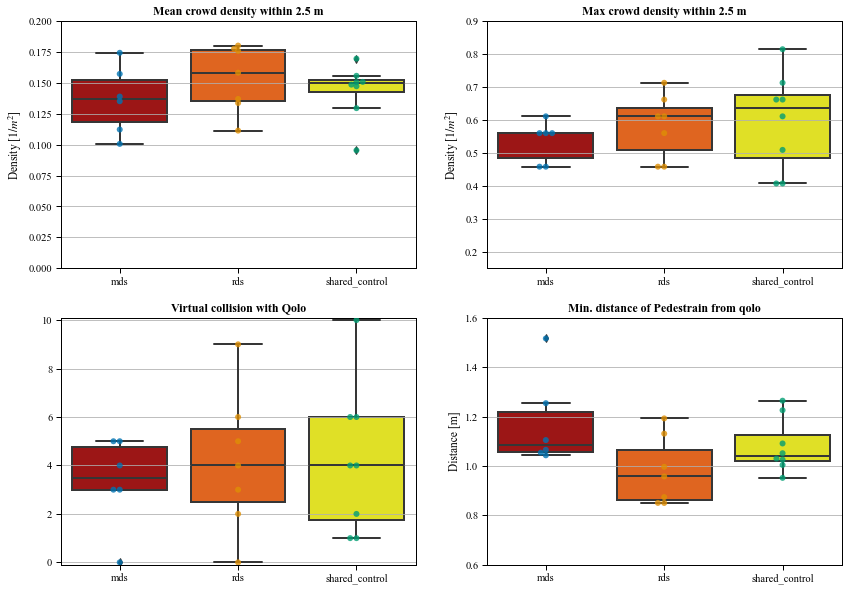

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

categorical_plot(
    axes=axes[0,0],
    df=crowd_metrics_df,
    metric='avg_crowd_density2_5',
    category='control_type',
    title='Mean crowd density within 2.5 m',
    xlabel='',
    ylabel='Density [$1/m^2$]',
    ylim=[0.00, 0.20],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)
categorical_plot(
    axes=axes[0,1],
    df=crowd_metrics_df,
    metric='max_crowd_density2_5',
    category='control_type',
    title='Max crowd density within 2.5 m',
    xlabel='',
    ylabel='Density [$1/m^2$]',
    ylim=[0.15, 0.90],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)

# categorical_plot(
#     axes=axes[1,0],
#     df=crowd_metrics_df,
#     metric='std_crowd_density2_5',
#     category='control_type',
#     title='Standard deviation of crowd density within 2.5 m',
#     xlabel='',
#     ylabel='Density [1/$m^2$]',
#     ylim=[0.0, 0.15],
#     kind='box',
#     # group='goal_reached',
#     # lgd_labels=['Not reached', 'Reached'],
# )

categorical_plot(
    axes=axes[1,0],
    df=crowd_metrics_df,
    metric='virtual_collision',
    category='control_type',
    title='Virtual collision with Qolo',
    xlabel='',
    ylabel='',
    ylim=[-0.1, 10.1],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)

categorical_plot(
    axes=axes[1,1],
    df=crowd_metrics_df,
    metric='avg_min_dist',
    category='control_type',
    title='Min. distance of Pedestrain from qolo',
    xlabel='',
    ylabel='Distance [m]',
    ylim=[0.6, 1.6],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)

plt.savefig("./pdf/0424_crowd.pdf", dpi=300)

plt.show()

In [23]:
plt.close()

### Path Efficiency-related metrics

- eval code

In [24]:
path_metrics_df = eval_res_df[['seq', 'control_type'] + list(path_metrics)]

- choose specific control type from final dataframe

In [25]:
path_metrics_df[path_metrics_df.control_type == 'shared_control']

,seq,control_type,rel_duration2goal,rel_path_length2goal,path_length2goal,duration2goal,min_dist2goal
13,2021-04-24-13-07-54,shared_control,0.247911,1.305326,18.816889,50.081827,6.440260
14,2021-04-24-13-11-03,shared_control,0.362650,1.449236,26.770664,47.756119,2.827538
15,2021-04-24-13-14-49,shared_control,0.233189,1.398963,17.272263,47.921671,7.789627
16,2021-04-24-13-16-58,shared_control,0.309931,1.218381,25.977917,56.751439,2.946275
17,2021-04-24-13-20-05,shared_control,0.287084,1.644409,28.864761,54.782662,4.458249
18,2021-04-24-13-22-52,shared_control,0.202016,1.338625,19.590395,76.341897,4.854780
19,2021-04-24-13-25-24-001,shared_control,0.299017,1.453586,21.852699,52.034866,17.468876
20,2021-04-24-13-27-09-003,shared_control,0.166739,2.777796,57.629929,97.016215,4.061659


In [26]:
for ctrl in chosen_type:
    print("###", ctrl)
    print("# mean")
    print(path_metrics_df[path_metrics_df.control_type == ctrl].mean(numeric_only=True))
    print("# std")
    print(path_metrics_df[path_metrics_df.control_type == ctrl].std(numeric_only=True))
    print()

### mds
# mean
rel_duration2goal        0.272513
rel_path_length2goal     1.545478
path_length2goal        22.745275
duration2goal           67.669832
min_dist2goal            5.610127
dtype: float64
# std
rel_duration2goal        0.090247
rel_path_length2goal     0.224333
path_length2goal         8.186058
duration2goal           16.672627
min_dist2goal            4.625392
dtype: float64

### rds
# mean
rel_duration2goal        0.337834
rel_path_length2goal     1.342999
path_length2goal        18.981937
duration2goal           55.745466
min_dist2goal            6.217194
dtype: float64
# std
rel_duration2goal        0.147670
rel_path_length2goal     0.259667
path_length2goal         6.585642
duration2goal           16.949095
min_dist2goal            4.569436
dtype: float64

### shared_control
# mean
rel_duration2goal        0.263567
rel_path_length2goal     1.573290
path_length2goal        27.096939
duration2goal           60.335837
min_dist2goal            6.355908
dtype: float64
# std

In [27]:
print("# max value in each metrics")
print(path_metrics_df.max(numeric_only=True))
print("# min value in each metrics")

print(path_metrics_df.min(numeric_only=True))

# max value in each metrics
rel_duration2goal        0.585570
rel_path_length2goal     2.777796
path_length2goal        57.629929
duration2goal           97.016215
min_dist2goal           17.468876
dtype: float64
# min value in each metrics
rel_duration2goal        0.166739
rel_path_length2goal     1.118626
path_length2goal         7.429669
duration2goal           35.591813
min_dist2goal            0.146512
dtype: float64


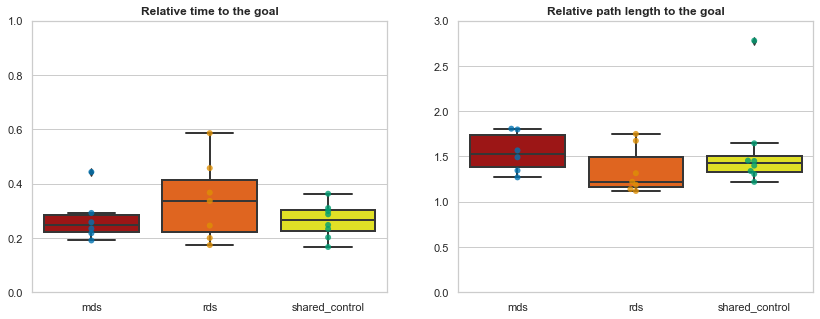

In [28]:
path_fig, path_axes = plt.subplots(1, 2, figsize=(14, 5))

categorical_plot(
    axes=path_axes[0],
    df=path_metrics_df,
    metric='rel_duration2goal',
    category='control_type',
    title='Relative time to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=path_axes[1],
    df=path_metrics_df,
    metric='rel_path_length2goal',
    category='control_type',
    title='Relative path length to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 3.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

plt.savefig("./pdf/0424_path_efficiency.pdf", dpi=300)

plt.show()

In [29]:
plt.close()

### Shared control-related metrics

In [30]:
control_metrics_df = eval_res_df[['seq', 'control_type'] + list(control_metrics)]

- choose specific control type from final dataframe

In [31]:
control_metrics_df[control_metrics_df.control_type == 'shared_control']

,seq,control_type,rel_jerk,avg_fluency,contribution,avg_agreement
13,2021-04-24-13-07-54,shared_control,0.175369,0.960532,0.476065,0.855482
14,2021-04-24-13-11-03,shared_control,0.159874,0.962289,0.370077,0.882208
15,2021-04-24-13-14-49,shared_control,0.164291,0.963631,0.843412,0.890127
16,2021-04-24-13-16-58,shared_control,0.160916,0.964951,0.515364,0.878205
17,2021-04-24-13-20-05,shared_control,0.168060,0.962249,0.528657,0.849144
18,2021-04-24-13-22-52,shared_control,0.158429,0.946228,0.629111,0.871567
19,2021-04-24-13-25-24-001,shared_control,0.180070,0.959594,0.439836,0.887174
20,2021-04-24-13-27-09-003,shared_control,0.171250,0.961486,0.543122,0.892709


In [32]:
for ctrl in chosen_type:
    print("###", ctrl)
    print("# mean")
    print(control_metrics_df[control_metrics_df.control_type == ctrl].mean(numeric_only=True))
    print("# std")
    print(control_metrics_df[control_metrics_df.control_type == ctrl].std(numeric_only=True))
    print()

### mds
# mean
rel_jerk         0.194991
avg_fluency      0.954550
contribution     0.576566
avg_agreement    0.706643
dtype: float64
# std
rel_jerk         0.036310
avg_fluency      0.002785
contribution     0.055931
avg_agreement    0.044491
dtype: float64

### rds
# mean
rel_jerk         0.115317
avg_fluency      0.994738
contribution     0.909364
avg_agreement    0.743709
dtype: float64
# std
rel_jerk         0.028581
avg_fluency      0.001690
contribution     0.132587
avg_agreement    0.032952
dtype: float64

### shared_control
# mean
rel_jerk         0.167283
avg_fluency      0.960120
contribution     0.543206
avg_agreement    0.875827
dtype: float64
# std
rel_jerk         0.007820
avg_fluency      0.005858
contribution     0.143257
avg_agreement    0.016074
dtype: float64



In [33]:
print("# max value in each metrics")
print(control_metrics_df.max(numeric_only=True))
print("# min value in each metrics")
print(control_metrics_df.min(numeric_only=True))

# max value in each metrics
rel_jerk         0.252785
avg_fluency      0.996798
contribution     1.108100
avg_agreement    0.892709
dtype: float64
# min value in each metrics
rel_jerk         0.073304
avg_fluency      0.946228
contribution     0.370077
avg_agreement    0.626400
dtype: float64


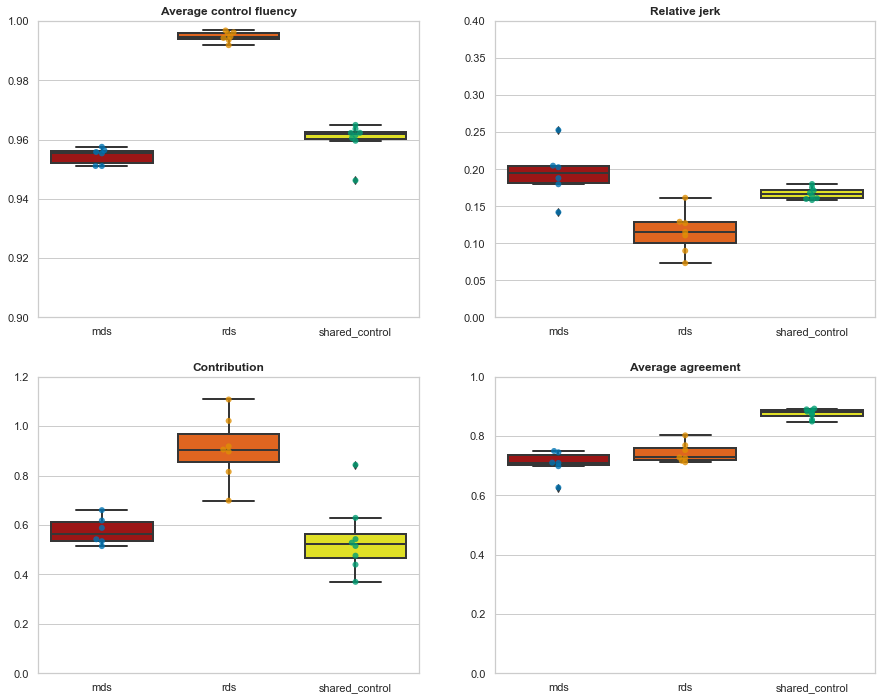

In [34]:
control_fig, control_axes = plt.subplots(2, 2, figsize=(15, 12))

categorical_plot(
    axes=control_axes[0,0],
    df=control_metrics_df,
    metric='avg_fluency',
    category='control_type',
    title='Average control fluency',
    xlabel='',
    ylabel='',
    ylim=[0.90, 1.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=control_axes[0,1],
    df=control_metrics_df,
    metric='rel_jerk',
    category='control_type',
    title='Relative jerk',
    xlabel='',
    ylabel='',
    ylim=[0, 0.4],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,0],
    df=control_metrics_df,
    metric='contribution',
    category='control_type',
    title='Contribution',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.2],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,1],
    df=control_metrics_df,
    metric='avg_agreement',
    category='control_type',
    title='Average agreement',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

plt.savefig("./pdf/0424_control.pdf", dpi=300)

plt.show()

In [35]:
plt.close()

## Example: 2021-04-10

In [36]:
chosen_dates = ['0410']
chosen_type = ['mds', 'rds', 'shared_control']

eval_dirs = []

for root, dirs, files in walk(outbase, topdown=False, maxdepth=1):
    for dir_ in dirs:
        if any(s in dir_ for s in chosen_dates) and any(s in dir_ for s in chosen_type):
            dir_ = dir_.replace("_processed", "")
            eval_dirs.append(dir_)
            print("{}/ is available!".format(dir_))

0410_mds/ is available!
0410_rds/ is available!
0410_shared_control/ is available!


### Result loading

In [37]:
eval_res_df = import_eval_res(eval_dirs)

Reading results from 0410_mds
Reading results from 0410_rds
Reading results from 0410_shared_control


### Crowd-related metrics

In [38]:
crowd_metrics_df = eval_res_df[['seq', 'control_type'] + list(crowd_metrics)]

In [39]:
for ctrl in chosen_type:
    print("###", ctrl)
    print("# mean")
    print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].mean(numeric_only=True))
    # print("# std")
    # print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].std(numeric_only=True))
    print()

### mds
# mean
avg_crowd_density2_5    0.102401
std_crowd_density2_5    0.074378
max_crowd_density2_5    0.402344
avg_crowd_density5      0.110323
std_crowd_density5      0.045033
max_crowd_density5      0.250828
avg_min_dist            1.199682
virtual_collision       3.600000
dtype: float64

### rds
# mean
avg_crowd_density2_5    0.115835
std_crowd_density2_5    0.080241
max_crowd_density2_5    0.403519
avg_crowd_density5      0.116271
std_crowd_density5      0.045129
max_crowd_density5      0.255627
avg_min_dist            1.130503
virtual_collision       8.615385
dtype: float64

### shared_control
# mean
avg_crowd_density2_5    0.088744
std_crowd_density2_5    0.074453
max_crowd_density2_5    0.420169
avg_crowd_density5      0.105671
std_crowd_density5      0.043323
max_crowd_density5      0.253056
avg_min_dist            1.311429
virtual_collision       4.250000
dtype: float64



In [40]:
print("# max value in each metrics")
print(crowd_metrics_df.max(numeric_only=True))
print("# min value in each metrics")
print(crowd_metrics_df.min(numeric_only=True))

# max value in each metrics
avg_crowd_density2_5     0.151217
std_crowd_density2_5     0.104738
max_crowd_density2_5     0.560225
avg_crowd_density5       0.131416
std_crowd_density5       0.055044
max_crowd_density5       0.318310
avg_min_dist             1.498774
virtual_collision       36.000000
dtype: float64
# min value in each metrics
avg_crowd_density2_5    0.072533
std_crowd_density2_5    0.059217
max_crowd_density2_5    0.305577
avg_crowd_density5      0.089543
std_crowd_density5      0.030495
max_crowd_density5      0.203718
avg_min_dist            0.804015
virtual_collision       0.000000
dtype: float64


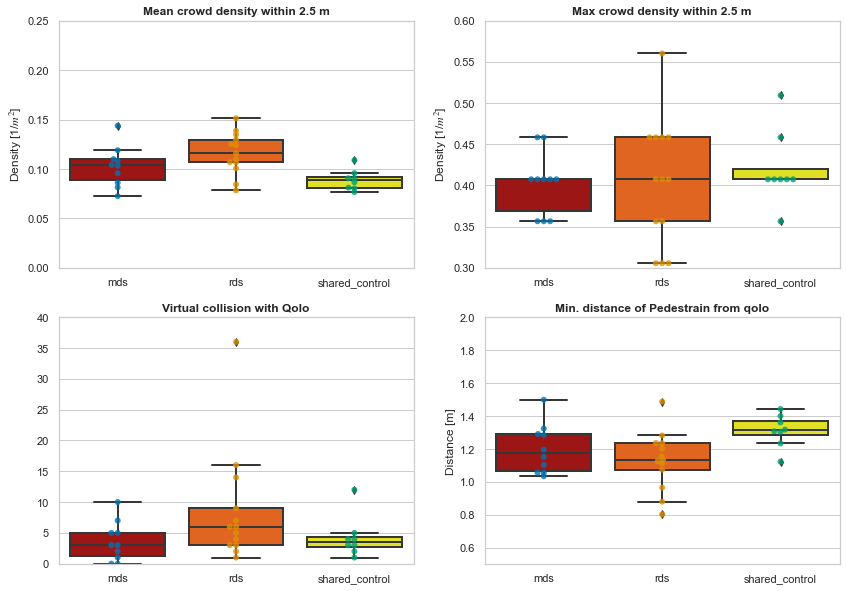

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

categorical_plot(
    axes=axes[0,0],
    df=crowd_metrics_df,
    metric='avg_crowd_density2_5',
    category='control_type',
    title='Mean crowd density within 2.5 m',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.00, 0.25],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)
categorical_plot(
    axes=axes[0,1],
    df=crowd_metrics_df,
    metric='max_crowd_density2_5',
    category='control_type',
    title='Max crowd density within 2.5 m',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.30, 0.60],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)

# categorical_plot(
#     axes=axes[1,0],
#     df=crowd_metrics_df,
#     metric='std_crowd_density2_5',
#     category='control_type',
#     title='Standard deviation of crowd density within 2.5 m',
#     xlabel='',
#     ylabel='Density [1/$m^2$]',
#     ylim=[0.0, 0.15],
#     kind='box',
#     # group='goal_reached',
#     # lgd_labels=['Not reached', 'Reached'],
# )

categorical_plot(
    axes=axes[1,0],
    df=crowd_metrics_df,
    metric='virtual_collision',
    category='control_type',
    title='Virtual collision with Qolo',
    xlabel='',
    ylabel='',
    ylim=[-0.1, 40],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)

categorical_plot(
    axes=axes[1,1],
    df=crowd_metrics_df,
    metric='avg_min_dist',
    category='control_type',
    title='Min. distance of Pedestrain from qolo',
    xlabel='',
    ylabel='Distance [m]',
    ylim=[0.5, 2.0],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)

plt.savefig("./pdf/0410_crowd.pdf", dpi=300)

plt.show()

In [42]:
plt.close()

### Path Efficiency-related metrics

In [43]:
path_metrics_df = eval_res_df[['seq', 'control_type'] + list(path_metrics)]

In [44]:
for ctrl in chosen_type:
    print("###", ctrl)
    print("# mean")
    print(path_metrics_df[path_metrics_df.control_type == ctrl].mean(numeric_only=True))
    print("# std")
    print(path_metrics_df[path_metrics_df.control_type == ctrl].std(numeric_only=True))
    print()

### mds
# mean
rel_duration2goal        0.288190
rel_path_length2goal     1.325668
path_length2goal        20.854128
duration2goal           72.082702
min_dist2goal            4.223129
dtype: float64
# std
rel_duration2goal        0.097573
rel_path_length2goal     0.150616
path_length2goal         4.432791
duration2goal           14.085057
min_dist2goal            3.819822
dtype: float64

### rds
# mean
rel_duration2goal        0.310687
rel_path_length2goal     1.331261
path_length2goal        21.252422
duration2goal           67.401774
min_dist2goal            7.038408
dtype: float64
# std
rel_duration2goal        0.068729
rel_path_length2goal     0.170277
path_length2goal         6.289336
duration2goal           22.513109
min_dist2goal           12.345414
dtype: float64

### shared_control
# mean
rel_duration2goal        0.323986
rel_path_length2goal     1.458339
path_length2goal        28.225304
duration2goal           57.129754
min_dist2goal            2.835881
dtype: float64
# std

In [45]:
print("# max value in each metrics")
print(path_metrics_df.max(numeric_only=True))
print("# min value in each metrics")
print(path_metrics_df.min(numeric_only=True))

# max value in each metrics
rel_duration2goal         0.470863
rel_path_length2goal      2.808815
path_length2goal         61.574150
duration2goal           126.312773
min_dist2goal            39.532685
dtype: float64
# min value in each metrics
rel_duration2goal        0.129141
rel_path_length2goal     1.056256
path_length2goal         7.513057
duration2goal           17.730146
min_dist2goal            0.282168
dtype: float64


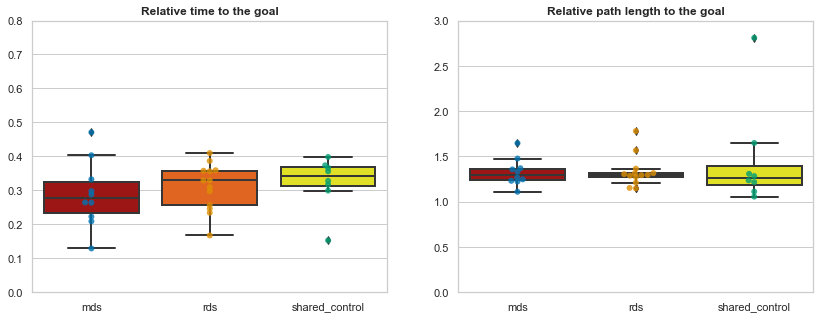

In [46]:
path_fig, path_axes = plt.subplots(1, 2, figsize=(14, 5))

categorical_plot(
    axes=path_axes[0],
    df=path_metrics_df,
    metric='rel_duration2goal',
    category='control_type',
    title='Relative time to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 0.8],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=path_axes[1],
    df=path_metrics_df,
    metric='rel_path_length2goal',
    category='control_type',
    title='Relative path length to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 3.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

plt.savefig("./pdf/0410_path_efficiency.pdf", dpi=300)

plt.show()

In [47]:
plt.close()

### Shared control-related metrics

In [48]:
control_metrics_df = eval_res_df[['seq', 'control_type'] + list(control_metrics)]

In [49]:
print("# max value in each metrics")
print(control_metrics_df.max(numeric_only=True))
print("# min value in each metrics")
print(control_metrics_df.min(numeric_only=True))

# max value in each metrics
rel_jerk         0.172762
avg_fluency      0.995213
contribution     1.025902
avg_agreement    0.909517
dtype: float64
# min value in each metrics
rel_jerk         0.030936
avg_fluency      0.918531
contribution     0.206484
avg_agreement    0.550326
dtype: float64


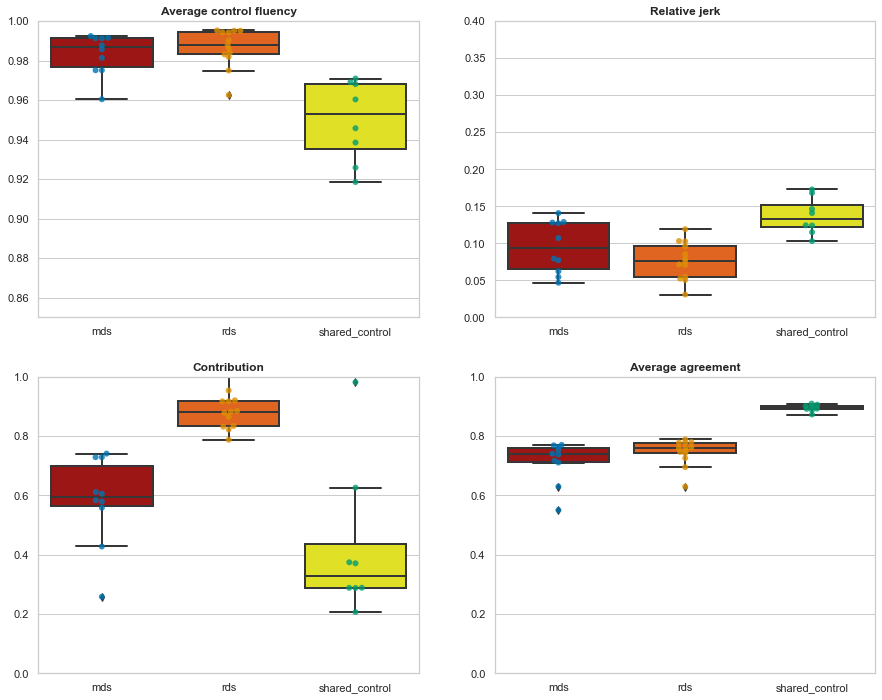

In [50]:
control_fig, control_axes = plt.subplots(2, 2, figsize=(15, 12))

categorical_plot(
    axes=control_axes[0,0],
    df=control_metrics_df,
    metric='avg_fluency',
    category='control_type',
    title='Average control fluency',
    xlabel='',
    ylabel='',
    ylim=[0.85, 1.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=control_axes[0,1],
    df=control_metrics_df,
    metric='rel_jerk',
    category='control_type',
    title='Relative jerk',
    xlabel='',
    ylabel='',
    ylim=[0, 0.4],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,0],
    df=control_metrics_df,
    metric='contribution',
    category='control_type',
    title='Contribution',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,1],
    df=control_metrics_df,
    metric='avg_agreement',
    category='control_type',
    title='Average agreement',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

plt.savefig("./pdf/0410_control.pdf", dpi=300)

plt.show()

In [51]:
plt.close()

## Example: 2021-12-03

In [52]:
chosen_dates = ['1203']
chosen_type = ['shared_control']

eval_dirs = []

for root, dirs, files in walk(outbase, topdown=False, maxdepth=1):
    for dir_ in dirs:
        if any(s in dir_ for s in chosen_dates) and any(s in dir_ for s in chosen_type):
            dir_ = dir_.replace("_processed", "")
            eval_dirs.append(dir_)
            print("{}/ is available!".format(dir_))

1203_shared_control/ is available!


### Results loading

In [53]:
eval_res_df = import_eval_res(eval_dirs)

Reading results from 1203_shared_control


### Crowd-related metrics

In [54]:
crowd_metrics_df = eval_res_df[['seq', 'control_type'] + list(crowd_metrics)]

In [55]:
print("###", ctrl)
print("# mean")
print(crowd_metrics_df.mean(numeric_only=True))
print("# std")
print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].std(numeric_only=True))

### shared_control
# mean
avg_crowd_density2_5     0.261741
std_crowd_density2_5     0.142428
max_crowd_density2_5     0.748273
avg_crowd_density5       0.180780
std_crowd_density5       0.078690
max_crowd_density5       0.421148
avg_min_dist             0.831233
virtual_collision       10.923077
dtype: float64
# std
avg_crowd_density2_5    0.038449
std_crowd_density2_5    0.013137
max_crowd_density2_5    0.093874
avg_crowd_density5      0.022898
std_crowd_density5      0.010976
max_crowd_density5      0.041409
avg_min_dist            0.089171
virtual_collision       9.031994
dtype: float64


In [56]:
print("# max")
print(crowd_metrics_df.max(numeric_only=True))
print()
print("# min")
print(crowd_metrics_df.min(numeric_only=True))

# max
avg_crowd_density2_5     0.327009
std_crowd_density2_5     0.167974
max_crowd_density2_5     0.916732
avg_crowd_density5       0.222670
std_crowd_density5       0.093452
max_crowd_density5       0.483831
avg_min_dist             0.953380
virtual_collision       36.000000
dtype: float64

# min
avg_crowd_density2_5    0.180332
std_crowd_density2_5    0.119456
max_crowd_density2_5    0.560225
avg_crowd_density5      0.157220
std_crowd_density5      0.057114
max_crowd_density5      0.343775
avg_min_dist            0.714396
virtual_collision       3.000000
dtype: float64


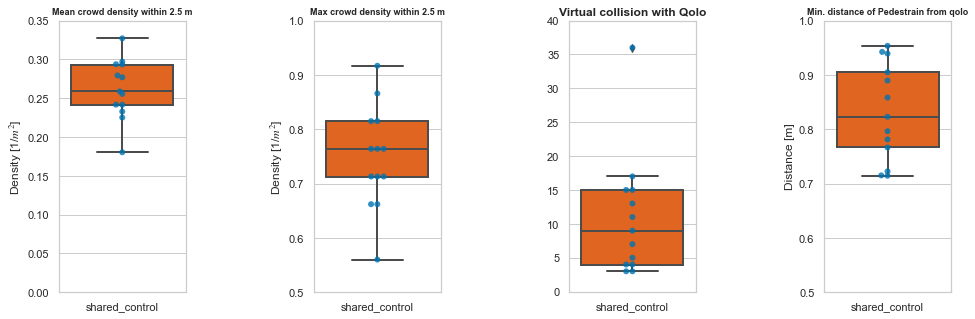

In [57]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.0, hspace=None)

categorical_plot(
    axes=axes[0],
    df=crowd_metrics_df,
    metric='avg_crowd_density2_5',
    category='control_type',
    title='Mean crowd density within 2.5 m',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.00, 0.35],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
    titlefontsz=9,
)
categorical_plot(
    axes=axes[1],
    df=crowd_metrics_df,
    metric='max_crowd_density2_5',
    category='control_type',
    title='Max crowd density within 2.5 m',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.50, 1.00],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
    titlefontsz=9,
)

# categorical_plot(
#     axes=axes[2],
#     df=crowd_metrics_df,
#     metric='std_crowd_density2_5',
#     category='control_type',
#     title='Standard deviation of crowd density within 2.5 m',
#     xlabel='',
#     ylabel='Density [1/$m^2$]',
#     ylim=[0.0, 0.20],
#     kind='box',
#     # group='goal_reached',
#     # lgd_labels=['Not reached', 'Reached'],
#     titlefontsz=9,
# )

categorical_plot(
    axes=axes[2],
    df=crowd_metrics_df,
    metric='virtual_collision',
    category='control_type',
    title='Virtual collision with Qolo',
    xlabel='',
    ylabel='',
    ylim=[-0.1, 40],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)

categorical_plot(
    axes=axes[3],
    df=crowd_metrics_df,
    metric='avg_min_dist',
    category='control_type',
    title='Min. distance of Pedestrain from qolo',
    xlabel='',
    ylabel='Distance [m]',
    ylim=[0.5, 1.0],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
    titlefontsz=9,
)

plt.savefig("./pdf/1203_crowd.pdf", dpi=300)

plt.show()

In [58]:
plt.close()

### Path Efficiency-related metrics

In [59]:
path_metrics_df = eval_res_df[['seq', 'control_type'] + list(path_metrics)]

In [60]:
for ctrl in chosen_type:
    print("###", ctrl)
    print("# mean")
    print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].mean(numeric_only=True))
    # print("# std")
    # print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].std(numeric_only=True))
    print()

### shared_control
# mean
avg_crowd_density2_5     0.261741
std_crowd_density2_5     0.142428
max_crowd_density2_5     0.748273
avg_crowd_density5       0.180780
std_crowd_density5       0.078690
max_crowd_density5       0.421148
avg_min_dist             0.831233
virtual_collision       10.923077
dtype: float64



In [61]:
print("# max value in each metrics")
print(path_metrics_df.max(numeric_only=True))
print("# min value in each metrics")
print(path_metrics_df.min(numeric_only=True))

# max value in each metrics
rel_duration2goal         0.450884
rel_path_length2goal     15.159015
path_length2goal         38.298992
duration2goal           165.341870
min_dist2goal            13.356678
dtype: float64
# min value in each metrics
rel_duration2goal        0.019995
rel_path_length2goal     1.065845
path_length2goal        29.225609
duration2goal           58.874716
min_dist2goal            0.027850
dtype: float64


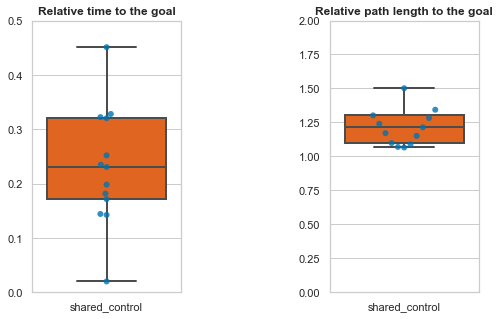

In [62]:
path_fig, path_axes = plt.subplots(1, 2, figsize=(8, 5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.0, hspace=None)

categorical_plot(
    axes=path_axes[0],
    df=path_metrics_df,
    metric='rel_duration2goal',
    category='control_type',
    title='Relative time to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 0.5],
    kind='box',
)

categorical_plot(
    axes=path_axes[1],
    df=path_metrics_df,
    metric='rel_path_length2goal',
    category='control_type',
    title='Relative path length to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 2.0],
    kind='box',
)

plt.savefig("./pdf/1203_path_efficiency.pdf", dpi=300)

plt.show()

In [63]:
plt.close()

### Shared control-related metrics

In [64]:
control_metrics_df = eval_res_df[['seq', 'control_type'] + list(control_metrics)]

In [65]:
print("# max value in each metrics")
print(control_metrics_df.max(numeric_only=True))
print("# min value in each metrics")
print(control_metrics_df.min(numeric_only=True))

# max value in each metrics
rel_jerk         0.201612
avg_fluency      0.957336
contribution     0.825493
avg_agreement    0.728184
dtype: float64
# min value in each metrics
rel_jerk         0.095763
avg_fluency      0.907108
contribution     0.572601
avg_agreement    0.647263
dtype: float64


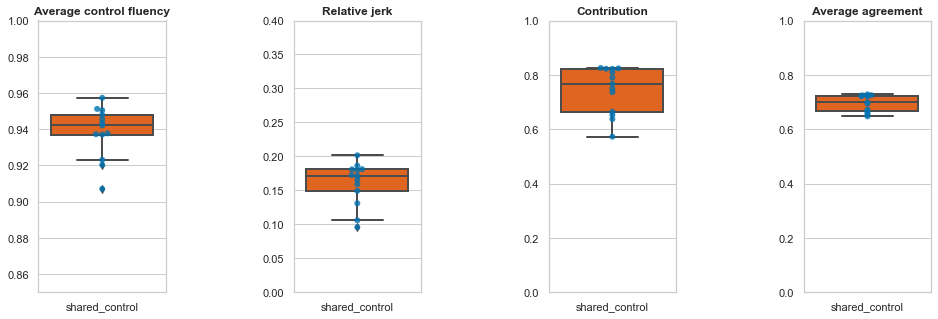

In [66]:
control_fig, control_axes = plt.subplots(1, 4, figsize=(16, 5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.0, hspace=None)



categorical_plot(
    axes=control_axes[0],
    df=control_metrics_df,
    metric='avg_fluency',
    category='control_type',
    title='Average control fluency',
    xlabel='',
    ylabel='',
    ylim=[0.85, 1.0],
    kind='box',
)

categorical_plot(
    axes=control_axes[1],
    df=control_metrics_df,
    metric='rel_jerk',
    category='control_type',
    title='Relative jerk',
    xlabel='',
    ylabel='',
    ylim=[0, 0.4],
    kind='box',
)

categorical_plot(
    axes=control_axes[2],
    df=control_metrics_df,
    metric='contribution',
    category='control_type',
    title='Contribution',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    kind='box',
)

categorical_plot(
    axes=control_axes[3],
    df=control_metrics_df,
    metric='avg_agreement',
    category='control_type',
    title='Average agreement',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    kind='box',
)

plt.savefig("./pdf/1203_control.pdf", dpi=300)

plt.show()

In [67]:
plt.close()

## Comparison of all control type between 0410 and 0424

### Result loading

In [68]:
chosen_dates = ['0410', '0424']
chosen_type = ['mds', 'rds', 'shared_control']

eval_dirs = []

for root, dirs, files in walk(outbase, topdown=False, maxdepth=1):
    for dir_ in dirs:
        if any(s in dir_ for s in chosen_dates) and any(s in dir_ for s in chosen_type):
            dir_ = dir_.replace("_processed", "")
            eval_dirs.append(dir_)
            print("{}/ is available!".format(dir_))

0410_mds/ is available!
0410_rds/ is available!
0410_shared_control/ is available!
0424_mds/ is available!
0424_rds/ is available!
0424_shared_control/ is available!


In [69]:
eval_res_df = import_eval_res(eval_dirs)

Reading results from 0410_mds
Reading results from 0410_rds
Reading results from 0410_shared_control
Reading results from 0424_mds
Reading results from 0424_rds
Reading results from 0424_shared_control


In [70]:
eval_res_df.head()

,seq,control_type,avg_crowd_density2_5,std_crowd_density2_5,max_crowd_density2_5,avg_crowd_density5,std_crowd_density5,max_crowd_density5,avg_min_dist,virtual_collision,rel_duration2goal,rel_path_length2goal,path_length2goal,duration2goal,min_dist2goal,rel_jerk,avg_fluency,contribution,avg_agreement,date
0,2021-04-10-11-28-10,mds,0.118972,0.082115,0.407437,0.121305,0.054506,0.292845,1.103109,3,0.222806,1.223162,18.631451,85.456764,4.768555,0.140807,0.960407,0.579491,0.740621,0410
1,2021-04-10-11-30-57,mds,0.086149,0.070451,0.407437,0.100127,0.049647,0.280113,1.283807,5,0.263975,1.331490,20.765743,73.851138,4.290847,0.127141,0.985675,0.427652,0.717045,0410
2,2021-04-10-11-33-46,mds,0.103987,0.067984,0.458366,0.108558,0.051738,0.267380,1.290971,0,0.470863,1.109684,18.319101,43.824839,3.166857,0.054578,0.991503,0.728803,0.770300,0410
3,2021-04-10-11-36-41,mds,0.072533,0.066247,0.407437,0.089543,0.040085,0.203718,1.324300,5,0.208948,1.356465,19.928324,87.888817,5.088686,0.077229,0.987672,0.728995,0.753914,0410
4,2021-04-10-11-54-34,mds,0.108386,0.069064,0.356507,0.122800,0.040368,0.229183,1.056874,3,0.129141,1.646356,10.646132,62.591449,13.899999,0.128074,0.975056,0.258358,0.550326,0410


### Mean-Std statistics

In [71]:
for ctrl in chosen_type:
    print(ctrl, ":", len(eval_res_df[eval_res_df.control_type == ctrl]))

frames_stat = []
for ctrl in chosen_type:
    eval_res_df_ = eval_res_df[eval_res_df.control_type == ctrl]
    stat_df = eval_res_df_.drop(['date'], axis=1).agg(['mean', 'std'])
    if ctrl == 'shared_control':
        stat_df.index = 'sc_'+stat_df.index.values
    else:
        stat_df.index = ctrl+'_'+stat_df.index.values
    frames_stat.append(stat_df)
    
stat_df_all = pd.concat(frames_stat) # , ignore_index=True
stat_df_all.index.name = 'Metrics'
stat_df_all

mds : 16
rds : 20
shared_control : 16


,avg_crowd_density2_5,std_crowd_density2_5,max_crowd_density2_5,avg_crowd_density5,std_crowd_density5,max_crowd_density5,avg_min_dist,virtual_collision,rel_duration2goal,rel_path_length2goal,path_length2goal,duration2goal,min_dist2goal,rel_jerk,avg_fluency,contribution,avg_agreement
Metrics,,,,,,,,,,,,,,,,,
mds_mean,0.115182,0.084864,0.452000,0.116808,0.049867,0.269768,1.189581,3.500000,0.282311,1.408097,21.563309,70.427876,4.743253,0.132651,0.972435,0.580148,0.711429
mds_std,0.028078,0.019079,0.080795,0.018398,0.009850,0.038680,0.158005,2.708013,0.092134,0.206072,5.917861,14.715994,4.045612,0.060549,0.016480,0.119643,0.060817
rds_mean,0.129016,0.089006,0.466006,0.126946,0.051916,0.284569,1.077405,7.050000,0.320189,1.335369,20.457752,63.322066,6.750983,0.089996,0.989375,0.894287,0.744966
rds_std,0.029029,0.016883,0.119469,0.020605,0.013657,0.053587,0.177220,7.917170,0.100230,0.199093,6.317681,21.056213,10.149561,0.031917,0.008680,0.090359,0.038866
sc_mean,0.116123,0.089108,0.509296,0.126017,0.052694,0.300007,1.195912,4.250000,0.293777,1.515815,27.661121,58.732795,4.595894,0.152049,0.954866,0.485626,0.885632
sc_std,0.032880,0.018044,0.139166,0.025297,0.010556,0.057502,0.156255,3.109126,0.074613,0.524430,13.122329,22.769335,3.964635,0.023729,0.015576,0.209203,0.016982


### Crowd-related metrics

In [72]:
crowd_metrics_df = eval_res_df[['seq', 'control_type'] + list(crowd_metrics) + ['date']]

In [73]:
for ctrl in chosen_type:
    print("###", ctrl)
    print("# mean")
    print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].mean(numeric_only=True))
    # print("# std")
    # print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].std(numeric_only=True))
    print()

### mds
# mean
avg_crowd_density2_5    0.115182
std_crowd_density2_5    0.084864
max_crowd_density2_5    0.452000
avg_crowd_density5      0.116808
std_crowd_density5      0.049867
max_crowd_density5      0.269768
avg_min_dist            1.189581
virtual_collision       3.500000
dtype: float64

### rds
# mean
avg_crowd_density2_5    0.129016
std_crowd_density2_5    0.089006
max_crowd_density2_5    0.466006
avg_crowd_density5      0.126946
std_crowd_density5      0.051916
max_crowd_density5      0.284569
avg_min_dist            1.077405
virtual_collision       7.050000
dtype: float64

### shared_control
# mean
avg_crowd_density2_5    0.116123
std_crowd_density2_5    0.089108
max_crowd_density2_5    0.509296
avg_crowd_density5      0.126017
std_crowd_density5      0.052694
max_crowd_density5      0.300007
avg_min_dist            1.195912
virtual_collision       4.250000
dtype: float64



In [74]:
print("# max value in each metrics")
print(crowd_metrics_df.max(numeric_only=True))
print("# min value in each metrics")
print(crowd_metrics_df.min(numeric_only=True))

# max value in each metrics
avg_crowd_density2_5     0.180251
std_crowd_density2_5     0.119700
max_crowd_density2_5     0.814873
avg_crowd_density5       0.169079
std_crowd_density5       0.084297
max_crowd_density5       0.394704
avg_min_dist             1.515852
virtual_collision       36.000000
dtype: float64
# min value in each metrics
avg_crowd_density2_5    0.072533
std_crowd_density2_5    0.059217
max_crowd_density2_5    0.305577
avg_crowd_density5      0.089543
std_crowd_density5      0.030495
max_crowd_density5      0.203718
avg_min_dist            0.804015
virtual_collision       0.000000
dtype: float64


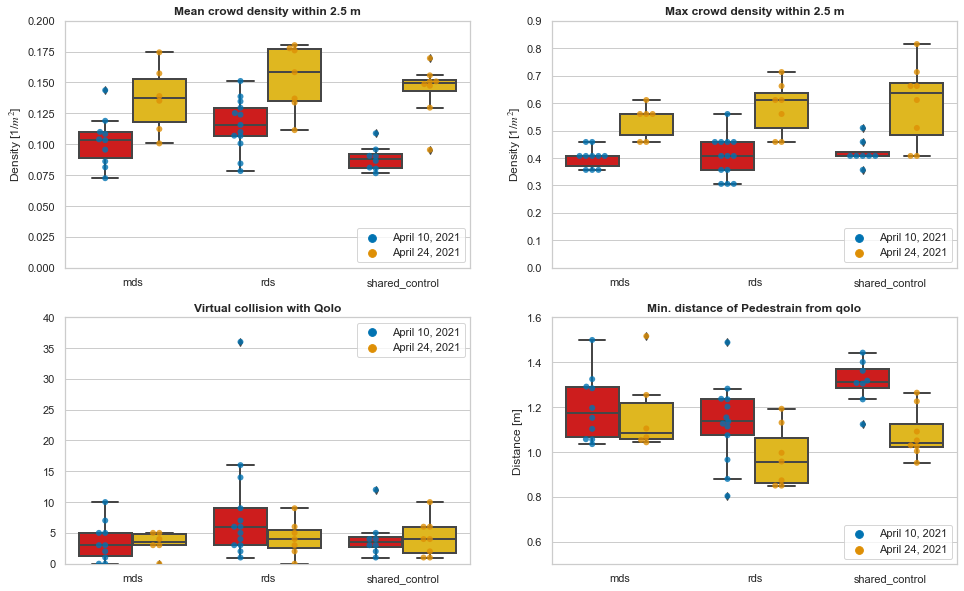

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

categorical_plot(
    axes=axes[0,0],
    df=crowd_metrics_df,
    metric='avg_crowd_density2_5',
    category='control_type',
    title='Mean crowd density within 2.5 m',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.0, 0.20],
    kind='box',
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
)
categorical_plot(
    axes=axes[0,1],
    df=crowd_metrics_df,
    metric='max_crowd_density2_5',
    category='control_type',
    title='Max crowd density within 2.5 m',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.0, 0.90],
    kind='box',
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
)

# categorical_plot(
#     axes=axes[1,0],
#     df=crowd_metrics_df,
#     metric='std_crowd_density2_5',
#     category='control_type',
#     title='Standard deviation of crowd density within 2.5 m',
#     xlabel='',
#     ylabel='Density [1/$m^2$]',
#     ylim=[0.0, 0.15],
#     kind='box',
#     lgd_labels=['April 10, 2021', 'April 24, 2021'],
#     group='date',
# )

categorical_plot(
    axes=axes[1,0],
    df=crowd_metrics_df,
    metric='virtual_collision',
    category='control_type',
    title='Virtual collision with Qolo',
    xlabel='',
    ylabel='',
    ylim=[-0.1, 40],
    kind='box',
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
    loc='upper right',
)

categorical_plot(
    axes=axes[1,1],
    df=crowd_metrics_df,
    metric='avg_min_dist',
    category='control_type',
    title='Min. distance of Pedestrain from qolo',
    xlabel='',
    ylabel='Distance [m]',
    ylim=[0.5, 1.6],
    kind='box',
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
)

plt.savefig("./pdf/comp_crowd.pdf", dpi=300)

plt.show()

In [76]:
plt.close()

### Path Efficiency-related metrics

In [77]:
path_metrics_df = eval_res_df[['seq', 'control_type'] + list(path_metrics) + ['date']]

In [78]:
print("# max value in each metrics")
print(path_metrics_df.max(numeric_only=True))
print("# min value in each metrics")
print(path_metrics_df.min(numeric_only=True))

# max value in each metrics
rel_duration2goal         0.585570
rel_path_length2goal      2.808815
path_length2goal         61.574150
duration2goal           126.312773
min_dist2goal            39.532685
dtype: float64
# min value in each metrics
rel_duration2goal        0.129141
rel_path_length2goal     1.056256
path_length2goal         7.429669
duration2goal           17.730146
min_dist2goal            0.146512
dtype: float64


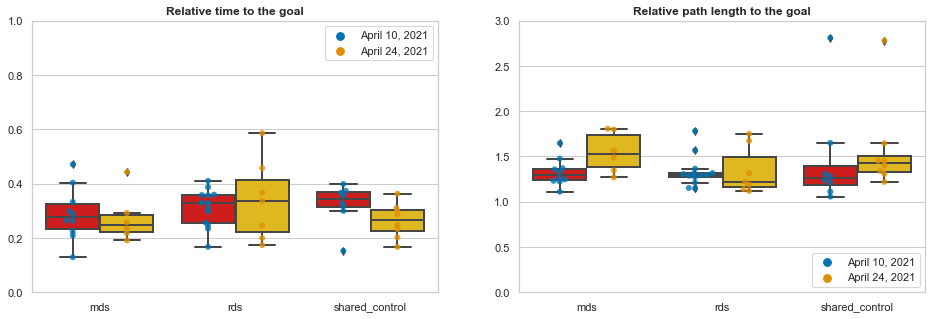

In [79]:
path_fig, path_axes = plt.subplots(1, 2, figsize=(16, 5))

categorical_plot(
    axes=path_axes[0],
    df=path_metrics_df,
    metric='rel_duration2goal',
    category='control_type',
    title='Relative time to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
    loc='upper right',
    kind='box',
)

categorical_plot(
    axes=path_axes[1],
    df=path_metrics_df,
    metric='rel_path_length2goal',
    category='control_type',
    title='Relative path length to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 3.0],
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
    kind='box',
)

plt.savefig("./pdf/comp_path_efficiency.pdf", dpi=300)

plt.show()

In [80]:
plt.close()

### Shared control-related metrics

In [81]:
control_metrics_df = eval_res_df[['seq', 'control_type'] + list(control_metrics) + ['date']]

In [82]:
print("# max value in each metrics")
print(control_metrics_df.max(numeric_only=True))
print("# min value in each metrics")
print(control_metrics_df.min(numeric_only=True))

# max value in each metrics
rel_jerk         0.252785
avg_fluency      0.996798
contribution     1.108100
avg_agreement    0.909517
dtype: float64
# min value in each metrics
rel_jerk         0.030936
avg_fluency      0.918531
contribution     0.206484
avg_agreement    0.550326
dtype: float64


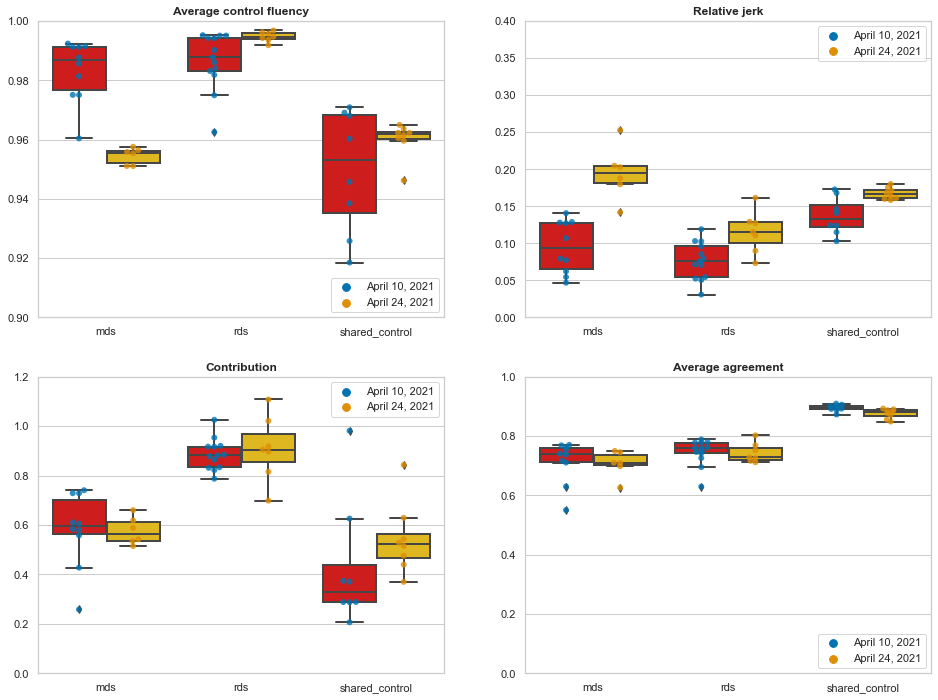

In [83]:
control_fig, control_axes = plt.subplots(2, 2, figsize=(16, 12))

categorical_plot(
    axes=control_axes[0,0],
    df=control_metrics_df,
    metric='avg_fluency',
    category='control_type',
    title='Average control fluency',
    xlabel='',
    ylabel='',
    ylim=[0.90, 1.0],
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
    kind='box',
)

categorical_plot(
    axes=control_axes[0,1],
    df=control_metrics_df,
    metric='rel_jerk',
    category='control_type',
    title='Relative jerk',
    xlabel='',
    ylabel='',
    ylim=[0, 0.4],
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
    loc='upper right',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,0],
    df=control_metrics_df,
    metric='contribution',
    category='control_type',
    title='Contribution',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.2],
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
    loc='upper right',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,1],
    df=control_metrics_df,
    metric='avg_agreement',
    category='control_type',
    title='Average agreement',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
    kind='box',
)

plt.savefig("./pdf/comp_control.pdf", dpi=300)

plt.show()

In [84]:
plt.close()

### Analysis without grouping by date

In [85]:
crowd_metrics_df0424 = crowd_metrics_df[crowd_metrics_df.date=='0424'].sort_values('control_type', ascending=False)
print("Sequence on 0424")
print(crowd_metrics_df0424['control_type'].value_counts())

Sequence on 0424
shared_control    8
rds               7
mds               6
Name: control_type, dtype: int64


In [86]:
crowd_metrics_df0410 = crowd_metrics_df[crowd_metrics_df.date=='0410'].sort_values(by=['control_type'], ascending=False, ignore_index=True).reindex()
print("Sequence on 0410")
print(crowd_metrics_df0410['control_type'].value_counts())

Sequence on 0410
rds               13
mds               10
shared_control     8
Name: control_type, dtype: int64


In [87]:
# crowd_metrics_df0410

Force to int ylabel!


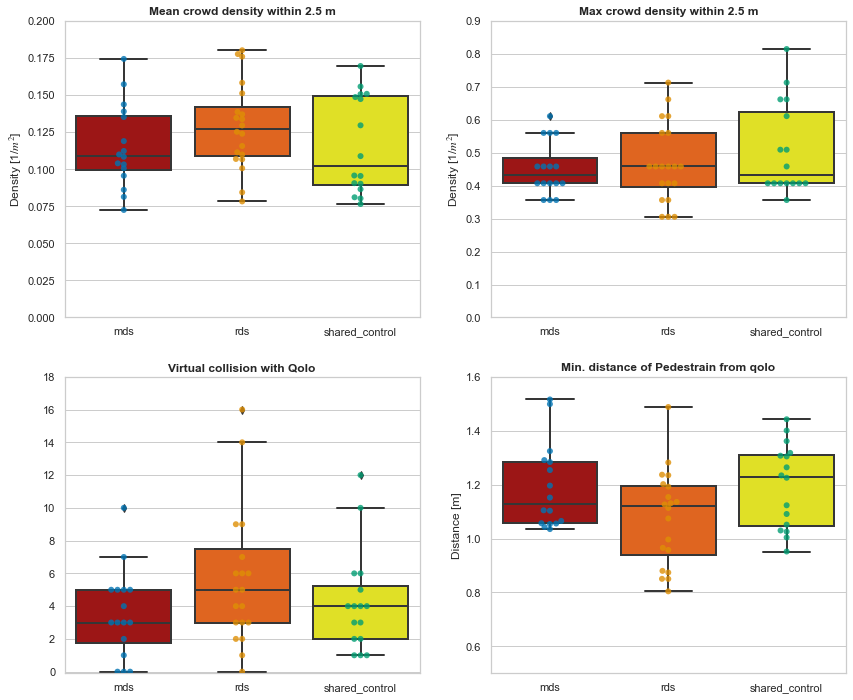

In [88]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

categorical_plot(
    axes=axes[0,0],
    df=crowd_metrics_df,
    metric='avg_crowd_density2_5',
    category='control_type',
    title='Mean crowd density within 2.5 m',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.0, 0.20],
    kind='box',
    #lgd_labels=['April 10, 2021', 'April 24, 2021'],
    #group='date',
)
categorical_plot(
    axes=axes[0,1],
    df=crowd_metrics_df,
    metric='max_crowd_density2_5',
    category='control_type',
    title='Max crowd density within 2.5 m',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.0, 0.90],
    kind='box',
    #lgd_labels=['April 10, 2021', 'April 24, 2021'],
    #group='date',
)

# categorical_plot(
#     axes=axes[1,0],
#     df=crowd_metrics_df,
#     metric='std_crowd_density2_5',
#     category='control_type',
#     title='Standard deviation of crowd density within 2.5 m',
#     xlabel='',
#     ylabel='Density [1/$m^2$]',
#     ylim=[0.0, 0.15],
#     kind='box',
#     #lgd_labels=['April 10, 2021', 'April 24, 2021'],
#     #group='date',
# )

categorical_plot(
    axes=axes[1,0],
    df=crowd_metrics_df,
    metric='virtual_collision',
    category='control_type',
    title='Virtual collision with Qolo',
    xlabel='',
    ylabel='',
    ylim=[-0.1, 18],
    kind='box',
    # lgd_labels=['April 10, 2021', 'April 24, 2021'],
    # group='date',
    # loc='upper right',
    yint=True,
    
)

categorical_plot(
    axes=axes[1,1],
    df=crowd_metrics_df,
    metric='avg_min_dist',
    category='control_type',
    title='Min. distance of Pedestrain from qolo',
    xlabel='',
    ylabel='Distance [m]',
    ylim=[0.5, 1.6],
    kind='box',
    #lgd_labels=['April 10, 2021', 'April 24, 2021'],
    #group='date',
)

plt.savefig("./pdf/comp_crowd_nogroup.pdf", dpi=300)

plt.show()

In [89]:
plt.close()

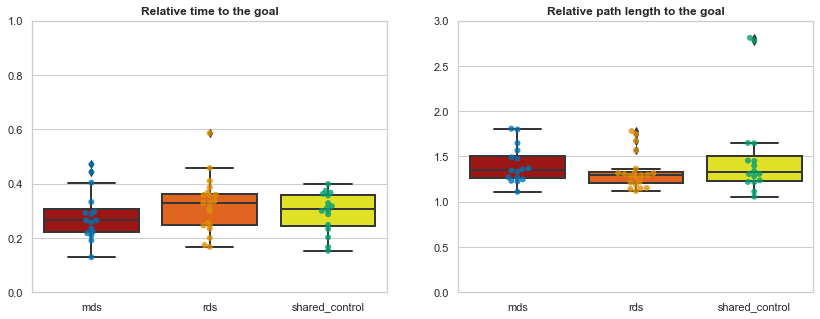

In [90]:
path_fig, path_axes = plt.subplots(1, 2, figsize=(14, 5))

categorical_plot(
    axes=path_axes[0],
    df=path_metrics_df,
    metric='rel_duration2goal',
    category='control_type',
    title='Relative time to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    # lgd_labels=['April 10, 2021', 'April 24, 2021'],
    # group='date',
    loc='upper right',
    kind='box',
)

categorical_plot(
    axes=path_axes[1],
    df=path_metrics_df,
    metric='rel_path_length2goal',
    category='control_type',
    title='Relative path length to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 3.0],
    # lgd_labels=['April 10, 2021', 'April 24, 2021'],
    # group='date',
    kind='box',
)

plt.savefig("./pdf/comp_path_efficiency_nogroup.pdf", dpi=300)

plt.show()

In [91]:
plt.close()

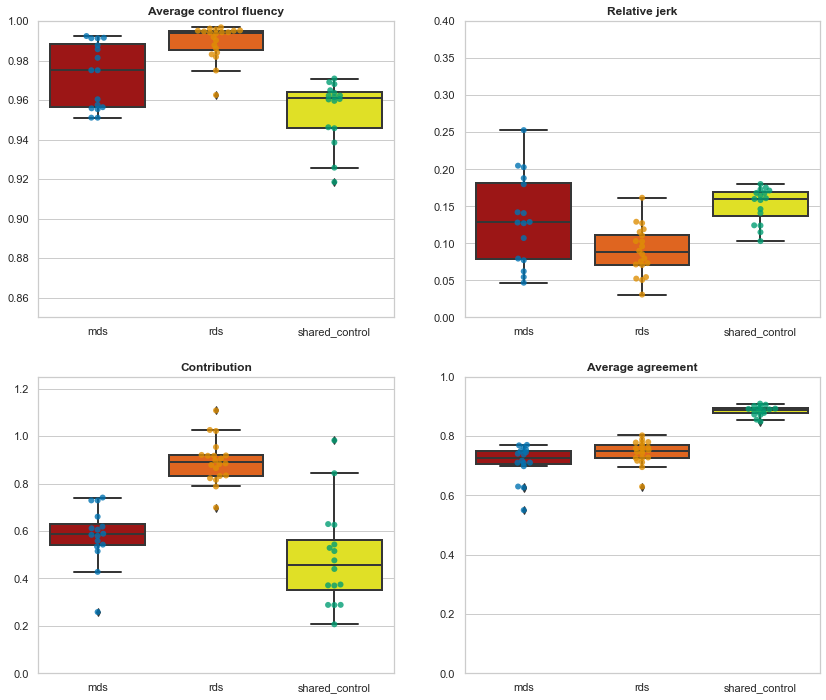

In [92]:
control_fig, control_axes = plt.subplots(2, 2, figsize=(14, 12))

categorical_plot(
    axes=control_axes[0,0],
    df=control_metrics_df,
    metric='avg_fluency',
    category='control_type',
    title='Average control fluency',
    xlabel='',
    ylabel='',
    ylim=[0.85, 1.0],
    # lgd_labels=['April 10, 2021', 'April 24, 2021'],
    # group='date',
    kind='box',
)

categorical_plot(
    axes=control_axes[0,1],
    df=control_metrics_df,
    metric='rel_jerk',
    category='control_type',
    title='Relative jerk',
    xlabel='',
    ylabel='',
    ylim=[0, 0.4],
    # lgd_labels=['April 10, 2021', 'April 24, 2021'],
    # group='date',
    loc='upper right',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,0],
    df=control_metrics_df,
    metric='contribution',
    category='control_type',
    title='Contribution',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.25],
    # lgd_labels=['April 10, 2021', 'April 24, 2021'],
    # group='date',
    loc='upper right',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,1],
    df=control_metrics_df,
    metric='avg_agreement',
    category='control_type',
    title='Average agreement',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    # lgd_labels=['April 10, 2021', 'April 24, 2021'],
    # group='date',
    kind='box',
)

plt.savefig("./pdf/comp_control_nogroup.pdf", dpi=300)

plt.show()

In [93]:
plt.close()

### ANOVA test

In [94]:
anova_metrics = (
    'rel_duration2goal',
    'rel_path_length2goal',
    'min_dist2goal',
    'avg_fluency',
    'contribution',
    'avg_agreement',
    'avg_crowd_density2_5',
    'max_crowd_density2_5',
    'avg_min_dist',
    'rel_jerk',
    'virtual_collision'
)

In [95]:
mds_anova_ = eval_res_df[eval_res_df.control_type=='mds']
mds_metrics = mds_anova_[list(anova_metrics)].values

rds_anova_ = eval_res_df[eval_res_df.control_type=='rds']
rds_metrics = rds_anova_[list(anova_metrics)].values

shared_control_anova_ = eval_res_df[eval_res_df.control_type=='shared_control']
shared_control_metrics = shared_control_anova_[list(anova_metrics)].values

In [96]:
fvalue12, pvalue12 = stats.f_oneway(mds_metrics, rds_metrics)
fvalue23, pvalue23 = stats.f_oneway(mds_metrics, shared_control_metrics)
fvalue13, pvalue13 = stats.f_oneway(rds_metrics, shared_control_metrics)
# total
fvalue, pvalue = stats.f_oneway(mds_metrics, rds_metrics, shared_control_metrics)

statP_df = pd.DataFrame(
    data=np.vstack((pvalue12, pvalue23, pvalue13, pvalue)), 
    index=['mds-rds', 'mds-shared', 'rds-shared', 'total'],
)
statP_df.columns = list(anova_metrics)
statP_df.index.name = 'Metrics'

statF_df = pd.DataFrame(
    data=np.vstack((fvalue12, fvalue23, fvalue13, fvalue)), 
    index=['mds-rds', 'mds-shared', 'rds-shared', 'total'],
)
statF_df.columns = list(anova_metrics)
statF_df.index.name = 'Metrics'

In [97]:
statP_df

,rel_duration2goal,rel_path_length2goal,min_dist2goal,avg_fluency,contribution,avg_agreement,avg_crowd_density2_5,max_crowd_density2_5,avg_min_dist,rel_jerk,virtual_collision
Metrics,,,,,,,,,,,
mds-rds,0.251201,0.291116,0.462180,3.539208e-04,1.701803e-10,5.248126e-02,0.158593,0.691098,0.055982,1.022116e-02,0.096183
mds-shared,0.701605,0.450434,0.917814,4.194127e-03,1.271729e-01,4.394447e-12,0.931220,0.164704,0.910031,2.421626e-01,0.472495
rds-shared,0.386874,0.164641,0.429249,7.744226e-10,3.495410e-09,3.542947e-15,0.220347,0.322395,0.043277,2.126847e-07,0.191799
total,0.437934,0.284891,0.587639,6.347837e-09,4.866865e-11,7.557426e-16,0.302198,0.349717,0.058731,1.235827e-04,0.124059


In [98]:
statF_df

,rel_duration2goal,rel_path_length2goal,min_dist2goal,avg_fluency,contribution,avg_agreement,avg_crowd_density2_5,max_crowd_density2_5,avg_min_dist,rel_jerk,virtual_collision
Metrics,,,,,,,,,,,
mds-rds,1.362644,1.149934,0.553056,15.752653,80.639450,4.037859,2.077901,0.160615,3.915727,7.395997,2.927673
mds-shared,0.149645,0.584740,0.010828,9.604399,2.461273,121.779797,0.007575,2.028381,0.012986,1.423601,0.529412
rds-shared,0.768367,2.017104,0.640046,70.976303,62.187073,181.071622,1.558959,1.008338,4.407619,41.859755,1.773586
total,0.839758,1.288384,0.537453,28.436203,40.079501,76.978797,1.226378,1.073482,3.005297,10.873499,2.178461


In [99]:
# print(statF_df.T.to_latex())
# print(statP_df.T.to_latex())
# print(stat_df_all.T.to_latex())

## Comparison between shared_control on 0325, 0410, 0424, and 1203

In [100]:
chosen_dates = ['0325', '0327', '0410', '0424', '1203']
chosen_type = ['shared_control']

eval_dirs = []

for root, dirs, files in walk(outbase, topdown=False, maxdepth=1):
    for dir_ in dirs:
        if any(s in dir_ for s in chosen_dates) and any(s in dir_ for s in chosen_type):
            dir_ = dir_.replace("_processed", "")
            eval_dirs.append(dir_)
            print("{}/ is available!".format(dir_))

0325_shared_control/ is available!
0327_shared_control/ is available!
0410_shared_control/ is available!
0424_shared_control/ is available!
1203_shared_control/ is available!


### Result loading

In [101]:
eval_res_df = import_eval_res(eval_dirs)

Reading results from 0325_shared_control
Reading results from 0327_shared_control
Reading results from 0410_shared_control
Reading results from 0424_shared_control
Reading results from 1203_shared_control


### Analysis given different dates

In [102]:
print("Shared_control sequence on different dates")
print(eval_res_df['date'].value_counts())

Shared_control sequence on different dates
0327    14
1203    13
0410     8
0424     8
0325     5
Name: date, dtype: int64


In [103]:
# eval_res_df.head()

#### Mean-Std statistics

In [104]:
frames_stat=[]
for date in chosen_dates:
    eval_res_df_ = eval_res_df[eval_res_df.date == date]
    stat_df = eval_res_df_.drop(['date'], axis=1).agg(['mean', 'std'])
    stat_df.index = date+'_'+stat_df.index.values
    frames_stat.append(stat_df)
    
stat_df_all_shared = pd.concat(frames_stat) # , ignore_index=True
stat_df_all_shared.index.name = 'Metrics'
stat_df_all_shared

,avg_crowd_density2_5,std_crowd_density2_5,max_crowd_density2_5,avg_crowd_density5,std_crowd_density5,max_crowd_density5,avg_min_dist,virtual_collision,rel_duration2goal,rel_path_length2goal,path_length2goal,duration2goal,min_dist2goal,rel_jerk,avg_fluency,contribution,avg_agreement
Metrics,,,,,,,,,,,,,,,,,
0325_mean,0.054568,0.054656,0.285206,0.063878,0.035999,0.211358,1.717142,1.400000,0.379606,1.198281,36.137142,68.606075,1.840448,0.120737,0.954195,0.654564,0.681743
0325_std,0.005142,0.001659,0.027895,0.008102,0.003034,0.017082,0.179279,1.673320,0.074838,0.217506,4.866597,12.143353,1.638693,0.025826,0.009416,0.162608,0.028696
0327_mean,0.187289,0.122211,0.665722,0.179175,0.068934,0.413803,0.941544,17.642857,0.290162,2.444374,43.154011,76.149608,7.315774,0.124112,0.963112,0.549693,0.715361
0327_std,0.030064,0.014814,0.064620,0.017112,0.008631,0.041709,0.139164,21.826614,0.122677,2.060132,12.005690,23.929199,7.531669,0.021247,0.010032,0.133325,0.024030
0410_mean,0.088744,0.074453,0.420169,0.105671,0.043323,0.253056,1.311429,4.250000,0.323986,1.458339,28.225304,57.129754,2.835881,0.136816,0.949613,0.428046,0.895437
0410_std,0.010305,0.008254,0.045144,0.010102,0.003511,0.030005,0.099335,3.370036,0.076341,0.573675,14.102476,28.293821,1.907087,0.024800,0.020554,0.256288,0.011826
0424_mean,0.143501,0.103763,0.598423,0.146364,0.062064,0.346958,1.080395,4.250000,0.263567,1.573290,27.096939,60.335837,6.355908,0.167283,0.960120,0.543206,0.875827
0424_std,0.022295,0.011776,0.145967,0.017971,0.005076,0.033858,0.109319,3.058945,0.063369,0.502683,13.014723,17.450916,4.792163,0.007820,0.005858,0.143257,0.016074
1203_mean,0.261741,0.142428,0.748273,0.180780,0.078690,0.421148,0.831233,10.923077,0.230464,2.283629,33.448952,101.372966,4.224270,0.160034,0.938521,0.744049,0.695130


#### ANOVA test

In [105]:
anova_metrics = (
    'rel_duration2goal',
    'rel_path_length2goal',
    'min_dist2goal',
    'avg_fluency',
    'contribution',
    'avg_agreement',
    'avg_crowd_density2_5',
    'max_crowd_density2_5',
    'avg_min_dist',
    'rel_jerk',
    'virtual_collision'
)

In [106]:
data1_anova_ = eval_res_df[eval_res_df.date=='0325']
date1 = data1_anova_[list(anova_metrics)].values

data2_anova_ = eval_res_df[eval_res_df.date=='0410']
date2 = data2_anova_[list(anova_metrics)].values

data3_anova_ = eval_res_df[eval_res_df.date=='0424']
date3 = data3_anova_[list(anova_metrics)].values

data4_anova_ = eval_res_df[eval_res_df.date=='1203']
date4 = data4_anova_[list(anova_metrics)].values

In [107]:
fvalue12, pvalue12 = stats.f_oneway(date1, date2)
fvalue23, pvalue23 = stats.f_oneway(date2, date3)
fvalue34, pvalue34 = stats.f_oneway(date3, date4)
fvalue13, pvalue13 = stats.f_oneway(date1, date3)
fvalue24, pvalue24 = stats.f_oneway(date2, date4)
fvalue14, pvalue14 = stats.f_oneway(date1, date4)
# total
fvalue, pvalue = stats.f_oneway(date1, date2, date3, date4)

statF_df = pd.DataFrame(
    data=np.vstack((fvalue12, fvalue13, fvalue14, fvalue23, fvalue24, fvalue34, fvalue)), 
    index=['12', '13', '14', '23', '24', '34', 'total'],
)
statF_df.columns = list(anova_metrics)
statF_df.index.name = 'Metrics'

statP_df = pd.DataFrame(
    data=np.vstack((pvalue12, pvalue13, pvalue14, pvalue23, pvalue24, pvalue34, pvalue)), 
    index=['12', '13', '14', '23', '24', '34', 'total'],
)
statP_df.columns = list(anova_metrics)
statP_df.index.name = 'Metrics'

In [108]:
statF_df

,rel_duration2goal,rel_path_length2goal,min_dist2goal,avg_fluency,contribution,avg_agreement,avg_crowd_density2_5,max_crowd_density2_5,avg_min_dist,rel_jerk,virtual_collision
Metrics,,,,,,,,,,,
12,1.656790,0.918200,0.926453,0.214626,3.070732,361.713180,46.554594,35.475322,28.189055,1.254849,3.031041
13,9.022480,2.430895,4.024035,1.997105,1.682762,249.860456,74.664454,21.808283,64.663777,23.684589,3.584294
14,7.839604,0.378181,1.685255,5.161379,2.390352,0.692441,138.962796,113.809388,202.455216,6.074854,5.292078
23,2.966760,0.181697,3.726240,1.933507,1.230688,7.724956,39.761354,10.888889,19.571476,10.981691,0.000000
24,4.513835,0.351972,0.865605,2.162449,17.159577,298.762109,152.359698,84.403077,131.906656,3.107198,3.958773
34,0.607833,0.261519,1.239884,16.653754,16.399761,228.149897,61.996024,8.289460,32.621791,0.397212,4.011839
total,4.251100,0.334092,2.076852,4.281824,6.826383,181.354152,105.438428,36.896096,84.064397,4.820695,4.095647


In [109]:
statP_df

,rel_duration2goal,rel_path_length2goal,min_dist2goal,avg_fluency,contribution,avg_agreement,avg_crowd_density2_5,max_crowd_density2_5,avg_min_dist,rel_jerk,virtual_collision
Metrics,,,,,,,,,,,
12,0.224462,0.358536,0.356468,0.652197,0.107503,9.161777e-10,2.864539e-05,9.508037e-05,2.488220e-04,0.286490,0.109544
13,0.011999,0.147254,0.070080,0.185267,0.221105,6.556864e-09,3.116572e-06,6.826151e-04,6.219310e-06,0.000497,0.084918
14,0.012843,0.547226,0.212630,0.037246,0.141635,4.175826e-01,2.661727e-09,1.108762e-08,1.681850e-10,0.025412,0.035214
23,0.106999,0.676400,0.074075,0.186085,0.285966,1.476736e-02,1.936870e-05,5.264049e-03,5.775682e-04,0.005119,1.000000
24,0.046966,0.559996,0.363846,0.157786,0.000553,4.437338e-13,1.606394e-10,2.025266e-08,5.414613e-10,0.094026,0.061217
34,0.445208,0.614970,0.279383,0.000637,0.000684,4.870230e-12,2.120866e-07,9.608771e-03,1.664902e-05,0.536040,0.059658
total,0.012876,0.800754,0.124279,0.012493,0.001214,2.586102e-19,4.982790e-16,3.432643e-10,1.064003e-14,0.007415,0.015015


In [110]:
# print(statF_df.T.to_latex())
# print(statP_df.T.to_latex())
# print(stat_df_all_shared.T.to_latex())

#### Crowd-related metrics

In [111]:
crowd_metrics_df = eval_res_df[['seq', 'control_type'] + list(crowd_metrics) + ['date']]

In [112]:
print("# max value in each metrics")
print(crowd_metrics_df.max(numeric_only=True))
print("# min value in each metrics")
print(crowd_metrics_df.min(numeric_only=True))

# max value in each metrics
avg_crowd_density2_5     0.327009
std_crowd_density2_5     0.167974
max_crowd_density2_5     0.916732
avg_crowd_density5       0.222670
std_crowd_density5       0.093452
max_crowd_density5       0.496563
avg_min_dist             1.921854
virtual_collision       92.000000
dtype: float64
# min value in each metrics
avg_crowd_density2_5    0.049439
std_crowd_density2_5    0.052378
max_crowd_density2_5    0.254648
avg_crowd_density5      0.053875
std_crowd_density5      0.033797
max_crowd_density5      0.190986
avg_min_dist            0.564863
virtual_collision       0.000000
dtype: float64


- group by date

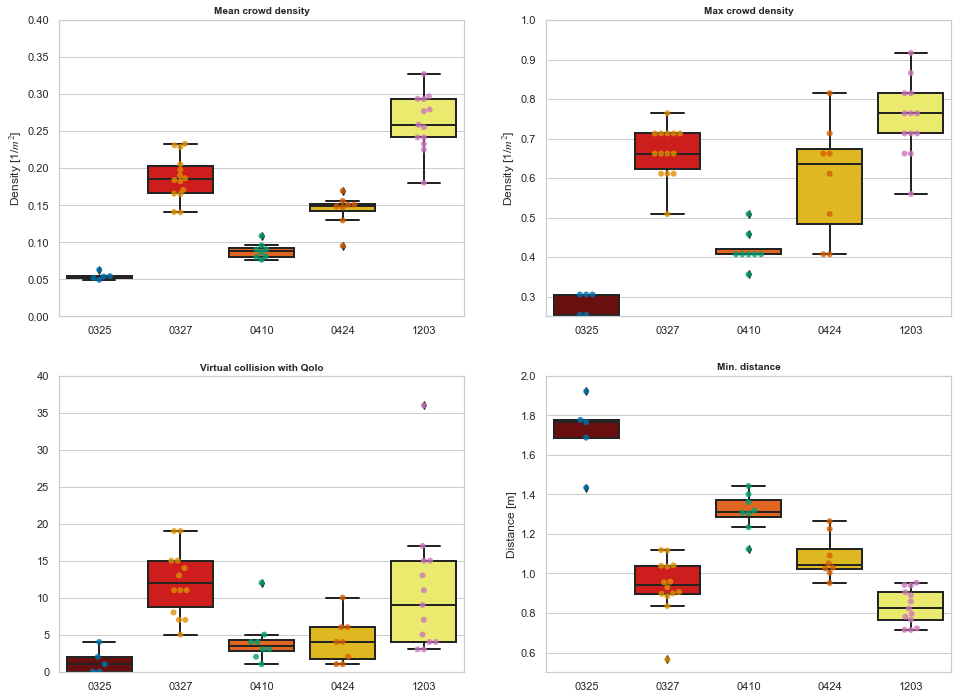

In [113]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

categorical_plot(
    axes=axes[0, 0],
    df=crowd_metrics_df,
    metric='avg_crowd_density2_5',
    category='date',
    # title='Mean crowd density within 2.5 m',
    title='Mean crowd density',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.00, 0.4],
    kind='box',
    # lgd_labels=['Mar 25, 2021', 'Mar 27, 2021', 'Apr 10, 2021', 'Apr 24, 2021', 'Dec 03, 2021'],
    lgd_labels=['Date 1', 'Date 2', 'Date 3', 'Date 4', 'Date 5'],
    titlefontsz=10,
)
categorical_plot(
    axes=axes[0, 1],
    df=crowd_metrics_df,
    metric='max_crowd_density2_5',
    category='date',
    # title='Max crowd density within 2.5 m',
    title='Max crowd density',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.25, 1.0],
    kind='box',
    # lgd_labels=['Mar 25, 2021', 'Mar 27, 2021', 'Apr 10, 2021', 'Apr 24, 2021', 'Dec 03, 2021'],
    lgd_labels=['Date 1', 'Date 2', 'Date 3', 'Date 4', 'Date 5'],
    titlefontsz=10,
)

categorical_plot(
    axes=axes[1, 0],
    df=crowd_metrics_df,
    metric='virtual_collision',
    category='date',
    title='Virtual collision with Qolo',
    xlabel='',
    ylabel='',
    ylim=[-0.1, 40],
    kind='box',
    # lgd_labels=['Mar 25, 2021', 'Mar 27, 2021', 'Apr 10, 2021', 'Apr 24, 2021', 'Dec 03, 2021'],
    lgd_labels=['Date 1', 'Date 2', 'Date 3', 'Date 4', 'Date 5'],
    titlefontsz=10,
    loc='upper left',
)

categorical_plot(
    axes=axes[1, 1],
    df=crowd_metrics_df,
    metric='avg_min_dist',
    category='date',
    # title='Min. distance of Pedestrain from qolo',
    title='Min. distance',
    xlabel='',
    ylabel='Distance [m]',
    ylim=[0.5, 2.0],
    kind='box',
    # lgd_labels=['Mar 25, 2021', 'Mar 27, 2021', 'Apr 10, 2021', 'Apr 24, 2021', 'Dec 03, 2021'],
    lgd_labels=['Date 1', 'Date 2', 'Date 3', 'Date 4', 'Date 5'],
    titlefontsz=10,
    loc='upper right',
)

plt.savefig("./pdf/all_shared_control_crowd_grouped.pdf", dpi=300)

plt.show()

In [114]:
plt.close()

- without grouping by date

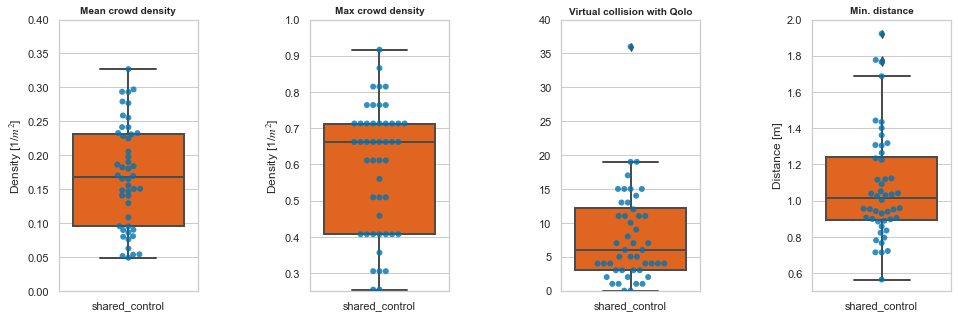

In [115]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=None)

categorical_plot(
    axes=axes[0],
    df=crowd_metrics_df,
    metric='avg_crowd_density2_5',
    category='control_type',
    # title='Mean crowd density within 2.5 m',
    title='Mean crowd density',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.00, 0.4],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
    titlefontsz=10,
)
categorical_plot(
    axes=axes[1],
    df=crowd_metrics_df,
    metric='max_crowd_density2_5',
    category='control_type',
    # title='Max crowd density within 2.5 m',
    title='Max crowd density',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.25, 1.0],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
    titlefontsz=10,
)

categorical_plot(
    axes=axes[2],
    df=crowd_metrics_df,
    metric='virtual_collision',
    category='control_type',
    title='Virtual collision with Qolo',
    xlabel='',
    ylabel='',
    ylim=[-0.1, 40],
    kind='box',
    titlefontsz=10,
)

categorical_plot(
    axes=axes[3],
    df=crowd_metrics_df,
    metric='avg_min_dist',
    category='control_type',
    # title='Min. distance of Pedestrain from qolo',
    title='Min. distance',
    xlabel='',
    ylabel='Distance [m]',
    ylim=[0.5, 2.0],
    kind='box',
    titlefontsz=10,
)

plt.savefig("./pdf/all_shared_control_crowd_nogrouped.pdf", dpi=300)

plt.show()

In [116]:
plt.close()

#### Path Efficiency-related metrics

In [117]:
path_metrics_df = eval_res_df[['seq', 'control_type'] + list(path_metrics) + ['date']]

- group by date

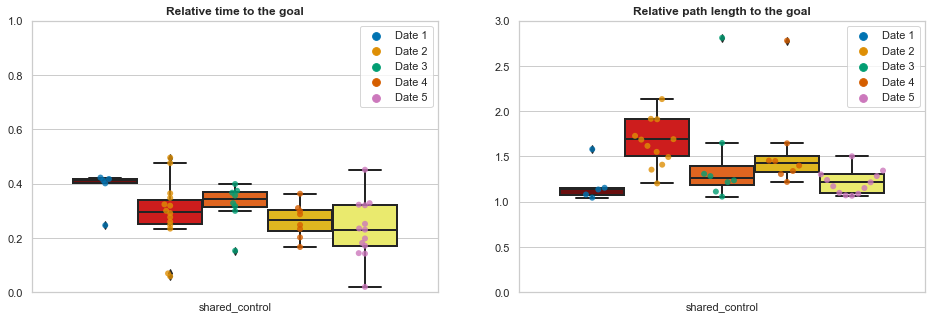

In [118]:
path_fig, path_axes = plt.subplots(1, 2, figsize=(16, 5))

categorical_plot(
    axes=path_axes[0],
    df=path_metrics_df,
    metric='rel_duration2goal',
    category='control_type',
    title='Relative time to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    # lgd_labels=['Mar 25, 2021', 'Mar 27, 2021', 'Apr 10, 2021', 'Apr 24, 2021', 'Dec 03, 2021'],
    lgd_labels=['Date 1', 'Date 2', 'Date 3', 'Date 4', 'Date 5'],
    group='date',
    loc='upper right',
    kind='box',
)

categorical_plot(
    axes=path_axes[1],
    df=path_metrics_df,
    metric='rel_path_length2goal',
    category='control_type',
    title='Relative path length to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 3.0],
    # lgd_labels=['Mar 25, 2021', 'Mar 27, 2021', 'Apr 10, 2021', 'Apr 24, 2021', 'Dec 03, 2021'],
    lgd_labels=['Date 1', 'Date 2', 'Date 3', 'Date 4', 'Date 5'],
    group='date',
    loc='upper right',
    kind='box',
)

plt.savefig("./pdf/all_shared_control_path_grouped.pdf", dpi=300)

plt.show()

In [119]:
plt.close()

- without grouping by date

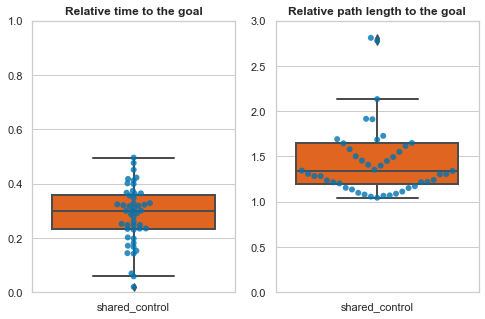

In [120]:
path_fig, path_axes = plt.subplots(1, 2, figsize=(8, 5))

# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=None)

categorical_plot(
    axes=path_axes[0],
    df=path_metrics_df,
    metric='rel_duration2goal',
    category='control_type',
    title='Relative time to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    # lgd_labels=['April 10, 2021', 'April 24, 2021'],
    # group='date',
    loc='upper right',
    kind='box',
)

categorical_plot(
    axes=path_axes[1],
    df=path_metrics_df,
    metric='rel_path_length2goal',
    category='control_type',
    title='Relative path length to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 3.0],
    # lgd_labels=['April 10, 2021', 'April 24, 2021'],
    # group='date',
    kind='box',
)

plt.savefig("./pdf/all_shared_control_path_nogrouped.pdf", dpi=300)

plt.show()

In [121]:
plt.close()

#### Shared control metrics

In [122]:
control_metrics_df = eval_res_df[['seq', 'control_type'] + list(control_metrics) + ['date']]

In [123]:
print("# max value in each metrics")
print(control_metrics_df.max(numeric_only=True))
print("# min value in each metrics")
print(control_metrics_df.min(numeric_only=True))

# max value in each metrics
rel_jerk         0.201612
avg_fluency      0.974402
contribution     0.981833
avg_agreement    0.909517
dtype: float64
# min value in each metrics
rel_jerk         0.076921
avg_fluency      0.907108
contribution     0.206484
avg_agreement    0.647263
dtype: float64


- group by date

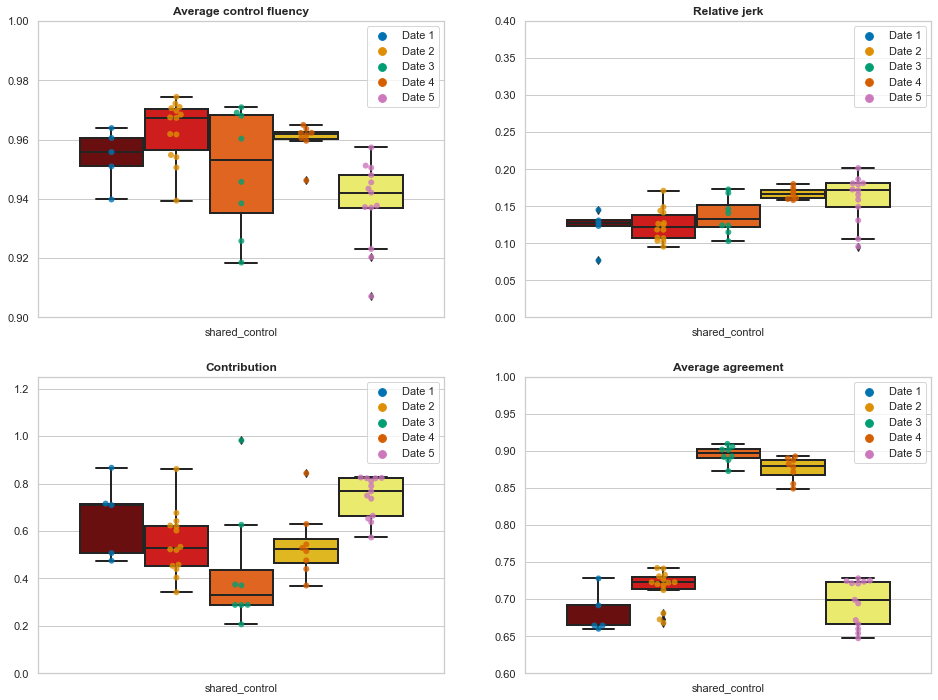

In [124]:
control_fig, control_axes = plt.subplots(2, 2, figsize=(16, 12))

categorical_plot(
    axes=control_axes[0,0],
    df=control_metrics_df,
    metric='avg_fluency',
    category='control_type',
    title='Average control fluency',
    xlabel='',
    ylabel='',
    ylim=[0.90, 1.0],
    # lgd_labels=['Mar 25, 2021', 'Mar 27, 2021', 'Apr 10, 2021', 'Apr 24, 2021', 'Dec 03, 2021'],
    lgd_labels=['Date 1', 'Date 2', 'Date 3', 'Date 4', 'Date 5'],
    group='date',
    loc='upper right',
    kind='box',
)

categorical_plot(
    axes=control_axes[0,1],
    df=control_metrics_df,
    metric='rel_jerk',
    category='control_type',
    title='Relative jerk',
    xlabel='',
    ylabel='',
    ylim=[0, 0.4],
    # lgd_labels=['Mar 25, 2021', 'Mar 27, 2021', 'Apr 10, 2021', 'Apr 24, 2021', 'Dec 03, 2021'],
    lgd_labels=['Date 1', 'Date 2', 'Date 3', 'Date 4', 'Date 5'],
    group='date',
    loc='upper right',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,0],
    df=control_metrics_df,
    metric='contribution',
    category='control_type',
    title='Contribution',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.25],
    # lgd_labels=['Mar 25, 2021', 'Mar 27, 2021', 'Apr 10, 2021', 'Apr 24, 2021', 'Dec 03, 2021'],
    lgd_labels=['Date 1', 'Date 2', 'Date 3', 'Date 4', 'Date 5'],
    group='date',
    loc='upper right',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,1],
    df=control_metrics_df,
    metric='avg_agreement',
    category='control_type',
    title='Average agreement',
    xlabel='',
    ylabel='',
    ylim=[0.60, 1.0],
    # lgd_labels=['Mar 25, 2021', 'Mar 27, 2021', 'Apr 10, 2021', 'Apr 24, 2021', 'Dec 03, 2021'],
    lgd_labels=['Date 1', 'Date 2', 'Date 3', 'Date 4', 'Date 5'],
    group='date',
    loc='upper right',
    kind='box',
)

plt.savefig("./pdf/all_shared_control_perf_grouped.pdf", dpi=300)

plt.show()

In [125]:
plt.close()

- without grouping by date

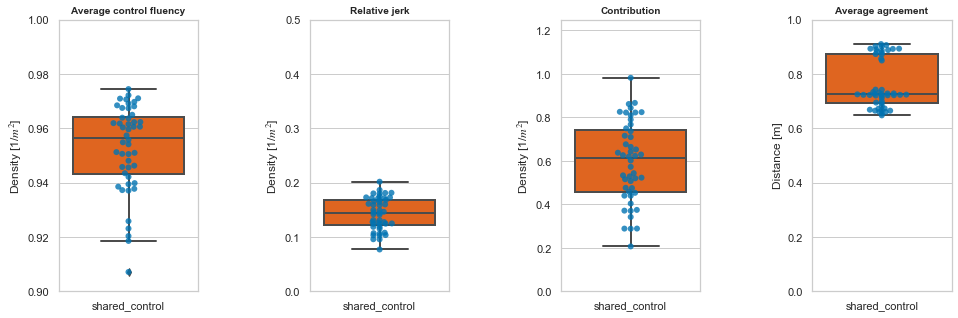

In [126]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=None)

categorical_plot(
    axes=axes[0],
    df=control_metrics_df,
    metric='avg_fluency',
    category='control_type',
    title='Average control fluency',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.90, 1.0],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
    titlefontsz=10,
)
categorical_plot(
    axes=axes[1],
    df=control_metrics_df,
    metric='rel_jerk',
    category='control_type',
    title='Relative jerk',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.0, 0.5],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
    titlefontsz=10,
)

categorical_plot(
    axes=axes[2],
    df=control_metrics_df,
    metric='contribution',
    category='control_type',
    title='Contribution',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.0, 1.25],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
    titlefontsz=10,
)

categorical_plot(
    axes=axes[3],
    df=control_metrics_df,
    metric='avg_agreement',
    category='control_type',
    title='Average agreement',
    xlabel='',
    ylabel='Distance [m]',
    ylim=[0.0, 1.0],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
    titlefontsz=10,
)

plt.savefig("./pdf/all_shared_control_perf_nogrouped.pdf", dpi=300)

plt.show()

In [127]:
plt.close()

### Analysis given cluster

> cluster the shared control tests by density of the crowd: Max_crowd_density: 
> 
> Perhaps (<0.35,  0.35 to 0.7,  >0.7)

#### Cluster according to crowd density metrics

In [128]:
# https://stackoverflow.com/a/64583481
# https://datascience.stackexchange.com/a/53932
from sklearn.cluster import KMeans

# possible input feature: 
# max_crowd_density2_5, 
# avg_crowd_density2_5, 
# std_crowd_density2_5, 
# max_crowd_density5,
# avg_crowd_density5,
eval_res_sorted_df = eval_res_df.sort_values('avg_crowd_density2_5', ascending=True, ignore_index=True).reindex()
shared_control_data_ = eval_res_sorted_df[['max_crowd_density2_5', 
                                         'avg_crowd_density2_5']]

# normalize 
# sklearn.preprocessing.StandardScaler
 
# Three cluster
model = KMeans(n_clusters=3)
model.fit(shared_control_data_)

KMeans(n_clusters=3)

In [129]:
clustered_labels = model.labels_
unique, unique_indices = np.unique(clustered_labels, return_index=True)
unique_indices

array([21,  0, 15])

In [130]:
index_dict = {
    0: np.where(clustered_labels == 0),
    1: np.where(clustered_labels == 1),
    2: np.where(clustered_labels == 2),
}

cluster_order = np.argsort(unique_indices)

for idx, ii in enumerate(cluster_order):
    if idx != ii:
        clustered_labels[index_dict[ii]] = idx
clustered_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2], dtype=int32)

In [131]:
# add date col
eval_res_sorted_df['cluster'] = clustered_labels

# eval_res_df_cluster = eval_res_df.sort_values('avg_crowd_density2_5', ascending=True, ignore_index=True).reindex()
print("Shared_control sequence on different cluster")
print(eval_res_sorted_df['cluster'].value_counts())

Shared_control sequence on different cluster
1    20
0    15
2    13
Name: cluster, dtype: int64


In [132]:
x_viz_data = shared_control_data_['max_crowd_density2_5'].values
y_viz_data = shared_control_data_['avg_crowd_density2_5'].values

##### Clustering results visualization by cluster

In [133]:
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'stix'

In [134]:
cmap = mpl.cm.get_cmap('hot')
cmap(0.35)

(0.9578411208447014, 0.0, 0.0, 1.0)

In [135]:
label_unique = np.unique(clustered_labels)

label_color_list = values2colors(clustered_labels, cmap_name='hot', range=(0.5, 0.8))
label_color_list = np.array(label_color_list)

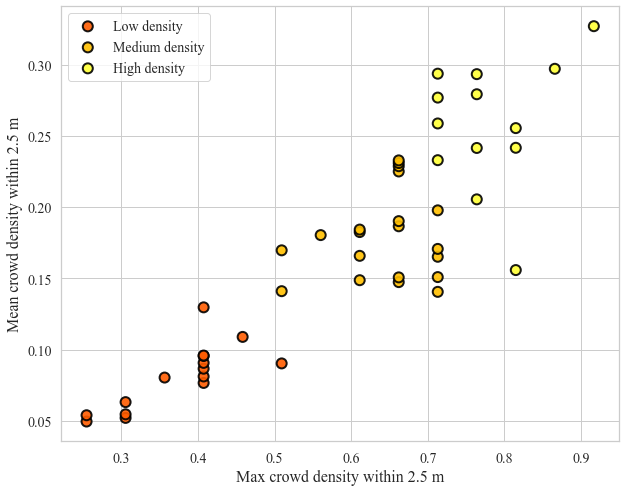

In [136]:
fig_cluster, axes_cluster = plt.subplots(figsize=(10, 8))

for label in label_unique:
    index = np.where(clustered_labels == label)
    axes_cluster.scatter(
        x=x_viz_data[index], 
        y=y_viz_data[index], 
        s=100,
        c=label_color_list[index], 
        alpha=0.9,
        cmap='hot',
        edgecolors='black', # None black
        linewidths=2,
        )
axes_cluster.set_xlabel("Max crowd density within 2.5 m", fontsize=16)
axes_cluster.set_ylabel("Mean crowd density within 2.5 m", fontsize=16)

axes_cluster.tick_params(axis='x', labelsize=14)
axes_cluster.tick_params(axis='y', labelsize=14)
axes_cluster.legend(['Low density', 'Medium density', 'High density'], fontsize=14)

plt.savefig("./pdf/pub/density_data_clustering_scatter_by_cluster.pdf", dpi=300)

plt.show()

In [137]:
plt.close()

##### Clustering results visualization by date

In [138]:
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'stix'

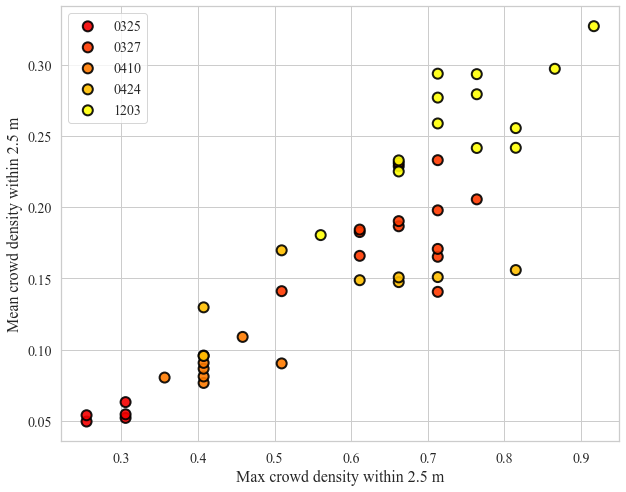

In [139]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html#qualitative

fig_cluster, axes_cluster = plt.subplots(figsize=(10, 8))
date_data = eval_res_sorted_df['date'].values
color_list = values2colors(date_data, cmap_name='hot', range=(0.35, 0.75))
color_list = np.array(color_list)
date_unique = np.unique(date_data)

for idx, date in enumerate(date_unique):
    index = np.where(date_data == date)
    axes_cluster.scatter(
        x=x_viz_data[index], 
        y=y_viz_data[index], 
        s=100,
        c=color_list[index], 
        alpha=0.9,
        edgecolors='black', # None black
        linewidths=2,
        )
    
axes_cluster.set_xlabel("Max crowd density within 2.5 m", fontsize=16)
axes_cluster.set_ylabel("Mean crowd density within 2.5 m", fontsize=16)

axes_cluster.legend(date_unique.tolist(), fontsize=14)
axes_cluster.tick_params(axis='x', labelsize=14)
axes_cluster.tick_params(axis='y', labelsize=14)

plt.savefig("./pdf/pub/density_shared_control_clustering_by_date.pdf", dpi=300)

plt.show()

In [140]:
plt.close()

In [141]:
# Desicion boundary plot
# ref: https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Utilities/ML-Python-utils.py
# ref: https://towardsdatascience.com/easily-visualize-scikit-learn-models-decision-boundaries-dd0fb3747508
# ValueError: Buffer dtype mismatch, expected 'double' but got 'float'

# h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    

# # Plot the decision boundary. For that, we will assign a color to each
# x_viz_data = shared_control_data_['max_crowd_density2_5'].values
# y_viz_data = shared_control_data_['avg_crowd_density2_5'].values

# x_min, x_max = x_viz_data.min() - 1, x_viz_data.max() + 1
# y_min, y_max = y_viz_data.min() - 1, y_viz_data.max() + 1

# # Meshgrid creation
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# data_xy = np.c_[xx.ravel(), yy.ravel()]
# data_xy.astype('double')
# Z = model.predict(data_xy)   

# plt.contourf(xx, yy, Z, alpha=0.4)

#### Mean-Std

In [142]:
frames_stat=[]
for idx in [0, 1, 2]:
    shared_cluster_stat_df = eval_res_sorted_df[eval_res_sorted_df.cluster == idx]
    stat_df = shared_cluster_stat_df.drop(['date', 'cluster'], axis=1).agg(['mean', 'std'])
    stat_df.index = 'cluster{}_'.format(idx)+stat_df.index.values
    frames_stat.append(stat_df)
    
all_shared_cluster_stat_df = pd.concat(frames_stat) # , ignore_index=True
all_shared_cluster_stat_df.index.name = 'Metrics'
all_shared_cluster_stat_df

,avg_crowd_density2_5,std_crowd_density2_5,max_crowd_density2_5,avg_crowd_density5,std_crowd_density5,max_crowd_density5,avg_min_dist,virtual_collision,rel_duration2goal,rel_path_length2goal,path_length2goal,duration2goal,min_dist2goal,rel_jerk,avg_fluency,contribution,avg_agreement
Metrics,,,,,,,,,,,,,,,,,
cluster0_mean,0.080525,0.069948,0.373484,0.094139,0.043284,0.246160,1.437776,2.933333,0.330378,1.459300,32.398052,63.274633,3.561321,0.136636,0.952597,0.512010,0.823473
cluster0_std,0.022977,0.014412,0.073720,0.024678,0.008648,0.038997,0.237672,2.939064,0.085942,0.571469,13.212399,23.758684,4.216360,0.028438,0.015865,0.228307,0.105218
cluster1_mean,0.179447,0.117265,0.644259,0.167873,0.067362,0.396614,0.955215,13.150000,0.303885,1.737467,37.073479,73.490796,5.936858,0.139646,0.956848,0.587719,0.748062
cluster1_std,0.030537,0.012966,0.062430,0.017593,0.008615,0.044159,0.125633,19.282594,0.098394,1.279478,13.000380,20.771676,6.536596,0.028505,0.017663,0.140928,0.079222
cluster2_mean,0.258359,0.143615,0.779614,0.186518,0.078049,0.423107,0.849000,12.076923,0.201799,2.885694,33.447376,95.981751,5.224301,0.154770,0.946712,0.690510,0.716711
cluster2_std,0.044725,0.012799,0.063695,0.021492,0.011357,0.040649,0.109426,8.499623,0.096931,4.066183,7.144266,37.475163,4.015689,0.031837,0.011738,0.152139,0.050548


#### ANOVA test

In [143]:
cluster0_anova_ = eval_res_sorted_df[eval_res_sorted_df.cluster==0]
c0_metrics = cluster0_anova_[list(anova_metrics)].values

cluster1_anova_ = eval_res_sorted_df[eval_res_sorted_df.cluster==1]
c1_metrics = cluster1_anova_[list(anova_metrics)].values

cluster2_anova_ = eval_res_sorted_df[eval_res_sorted_df.cluster==0]
c2_metrics = cluster2_anova_[list(anova_metrics)].values

In [144]:
fvalue01, pvalue01 = stats.f_oneway(c0_metrics, c1_metrics)
fvalue02, pvalue02 = stats.f_oneway(c0_metrics, c2_metrics)
fvalue12, pvalue12 = stats.f_oneway(c1_metrics, c2_metrics)
# total
fvalue, pvalue = stats.f_oneway(c0_metrics, c1_metrics, c2_metrics)

statP_df = pd.DataFrame(
    data=np.vstack((pvalue01, pvalue02, pvalue12, pvalue)), 
    index=['c0-c1', 'c0-c2', 'c1-c2', 'total'],
)
statP_df.columns = list(anova_metrics)
statP_df.index.name = 'Metrics'

statF_df = pd.DataFrame(
    data=np.vstack((fvalue01, fvalue02, fvalue12, fvalue)), 
    index=['c0-c1', 'c0-c2', 'c1-c2', 'total'],
)
statF_df.columns = list(anova_metrics)
statF_df.index.name = 'Metrics'

In [145]:
statP_df

,rel_duration2goal,rel_path_length2goal,min_dist2goal,avg_fluency,contribution,avg_agreement,avg_crowd_density2_5,max_crowd_density2_5,avg_min_dist,rel_jerk,virtual_collision
Metrics,,,,,,,,,,,
c0-c1,0.411814,0.439067,0.228605,0.467274,0.234817,0.021096,4.712817e-12,2.446430e-13,5.931100e-09,0.758870,0.050798
c0-c2,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,NaN,1.000000,NaN
c1-c2,0.411814,0.439067,0.228605,0.467274,0.234817,0.021096,4.712817e-12,2.446430e-13,5.931100e-09,0.758870,0.050798
total,0.605812,0.585096,0.305809,0.677379,0.421508,0.031199,2.490245e-16,6.351929e-17,5.119805e-10,0.935175,0.024274


In [146]:
statF_df

,rel_duration2goal,rel_path_length2goal,min_dist2goal,avg_fluency,contribution,avg_agreement,avg_crowd_density2_5,max_crowd_density2_5,avg_min_dist,rel_jerk,virtual_collision
Metrics,,,,,,,,,,,
c0-c1,6.909538e-01,0.613476,1.504864e+00,0.540854,1.464473e+00,5.865649,1.102351e+02,138.131419,6.038873e+01,9.580463e-02,4.108938e+00
c0-c2,-3.233356e-31,0.000000,1.656616e-31,0.000000,1.812965e-31,0.000000,5.350269e-31,0.000000,-1.541976e-30,2.778403e-31,-5.859923e-32
c1-c2,6.909538e-01,0.613476,1.504864e+00,0.540854,1.464473e+00,5.865649,1.102351e+02,138.131419,6.038873e+01,9.580463e-02,4.108938e+00
total,5.065686e-01,0.542139,1.215171e+00,0.392770,8.799916e-01,3.736247,8.490706e+01,91.396267,3.490080e+01,6.711740e-02,4.028683e+00


In [147]:
# print(statF_df.T.to_latex())
# print(statP_df.T.to_latex())
# print(stat_df_all_shared_cluster_stat.T.to_latex())

#### Crowd-related metrics

In [148]:
crowd_metrics_df = eval_res_sorted_df[['seq', 'control_type'] + list(crowd_metrics) + ['cluster']]

In [149]:
crowd_metrics_df.head()

,seq,control_type,avg_crowd_density2_5,std_crowd_density2_5,max_crowd_density2_5,avg_crowd_density5,std_crowd_density5,max_crowd_density5,avg_min_dist,virtual_collision,cluster
0,2021-03-25-15-01-50,shared_control,0.049439,0.052378,0.254648,0.067806,0.033821,0.190986,1.686864,0,0
1,2021-03-25-15-04-27,shared_control,0.051985,0.054652,0.305577,0.053875,0.033797,0.203718,1.765421,1,0
2,2021-03-25-14-52-33,shared_control,0.053860,0.054466,0.254648,0.061735,0.033850,0.203718,1.776971,2,0
3,2021-03-25-14-54-51,shared_control,0.054485,0.057059,0.305577,0.060614,0.040070,0.229183,1.921854,0,0
4,2021-03-25-14-57-34,shared_control,0.063069,0.054728,0.305577,0.075359,0.038457,0.229183,1.434601,4,0


##### Original 4-in-1 plotting

In [150]:
value_unique, color_unique = values2color_list(
        eval_res_sorted_df['cluster'].values, cmap_name='hot', range=(0.5, 0.8)
    )

value_unique, point_color_unique = values2color_list(
        eval_res_sorted_df['cluster'].values, cmap_name='hot', range=(0.3, 0.6)
    )

# creating a dictionary with one specific color per group:
box_pal = {value_unique[i]: color_unique[i] for i in range(len(value_unique))}
scatter_pal = {value_unique[i]: point_color_unique[i] for i in range(len(value_unique))}
box_pal, scatter_pal

({0: (1.0, 0.359314099938117, 0.0, 1.0),
  1: (1.0, 0.7504899348656205, 0.0, 1.0),
  2: (1.0, 1.0, 0.21249921249921258, 1.0)},
 {0: (0.8240081481370484, 0.0, 0.0, 1.0),
  1: (1.0, 0.22549078798923422, 0.0, 1.0),
  2: (1.0, 0.6166666229167378, 0.0, 1.0)})

In [151]:
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'stix'

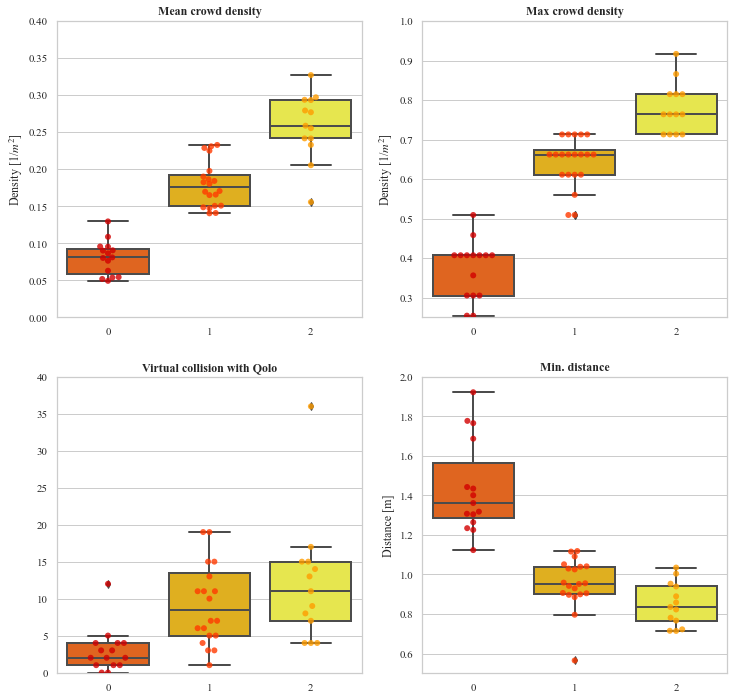

In [152]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

categorical_plot(
    axes=axes[0, 0],
    df=eval_res_sorted_df,
    metric='avg_crowd_density2_5',
    category='cluster',
    # title='Mean crowd density within 2.5 m',
    title='Mean crowd density',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.00, 0.4],
    kind='box',
    lgd_labels=['Cluster 1', 'Cluster 2', 'Cluster 3'],
    box_palette=box_pal,
    scatter_palette=scatter_pal,
)
categorical_plot(
    axes=axes[0, 1],
    df=eval_res_sorted_df,
    metric='max_crowd_density2_5',
    category='cluster',
    # title='Max crowd density within 2.5 m',
    title='Max crowd density',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.25, 1.0],
    kind='box',
    lgd_labels=['Cluster 1', 'Cluster 2', 'Cluster 3'],
    box_palette=box_pal,
    scatter_palette=scatter_pal,
)

categorical_plot(
    axes=axes[1, 0],
    df=eval_res_sorted_df,
    metric='virtual_collision',
    category='cluster',
    title='Virtual collision with Qolo',
    xlabel='',
    ylabel='',
    ylim=[-0.1, 40],
    kind='box',
    lgd_labels=['Cluster 1', 'Cluster 2', 'Cluster 3'],
    box_palette=box_pal,
    scatter_palette=scatter_pal,
)

categorical_plot(
    axes=axes[1, 1],
    df=eval_res_sorted_df,
    metric='avg_min_dist',
    category='cluster',
    # title='Min. distance of Pedestrain from qolo',
    title='Min. distance',
    xlabel='',
    ylabel='Distance [m]',
    ylim=[0.5, 2.0],
    kind='box',
    lgd_labels=['Cluster 1', 'Cluster 2', 'Cluster 3'],
    box_palette=box_pal,
    scatter_palette=scatter_pal,
)

plt.savefig("./pdf/all_shared_control_crowd_grouped_cluster.pdf", dpi=300)

plt.show()

In [153]:
plt.close()

##### Updated plotting

In [154]:
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'stix'

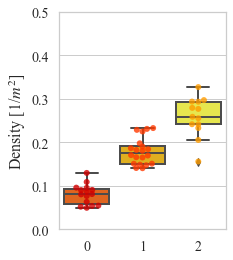

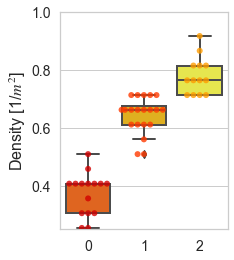

/home/crowdbot/miniconda3/envs/py38cuda110/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


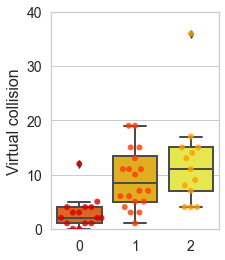

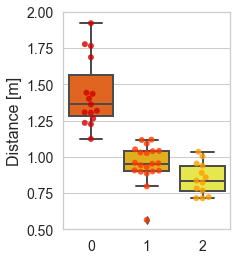

In [155]:
dense_fig1, dense_axes1 = plt.subplots(figsize=(3, 4))

categorical_plot(
    axes=dense_axes1,
    df=eval_res_sorted_df,
    metric='avg_crowd_density2_5',
    category='cluster',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.00, 0.50],
    kind='box',
    lgd_labels=['Cluster 1', 'Cluster 2', 'Cluster 3'],
    box_palette=box_pal,
    scatter_palette=scatter_pal,
)

dense_axes1.set_ylabel("Density [1/$m^2$]", fontsize=16)

# axes_cluster.legend(date_unique.tolist(), fontsize=14)
dense_axes1.tick_params(axis='x', labelsize=14)
dense_axes1.tick_params(axis='y', labelsize=14)

plt.savefig("./pdf/pub/density_boxplot_mean_density_2_5.pdf", dpi=300)

plt.show()

###################################################
###################################################

dense_fig2, dense_axes2 = plt.subplots(figsize=(3, 4))

categorical_plot(
    axes=dense_axes2,
    df=eval_res_sorted_df,
    metric='max_crowd_density2_5',
    category='cluster',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.25, 1.0],
    kind='box',
    lgd_labels=['Cluster 1', 'Cluster 2', 'Cluster 3'],
    box_palette=box_pal,
    scatter_palette=scatter_pal,
)

dense_axes2.set_ylabel("Density [1/$m^2$]", fontsize=16)

# axes_cluster.legend(date_unique.tolist(), fontsize=14)
dense_axes2.tick_params(axis='x', labelsize=14)
dense_axes2.tick_params(axis='y', labelsize=14)

plt.savefig("./pdf/pub/density_boxplot_max_density_2_5.pdf", dpi=300)

plt.show()

###################################################
###################################################

dense_fig3, dense_axes3 = plt.subplots(figsize=(3, 4))

categorical_plot(
    axes=dense_axes3,
    df=eval_res_sorted_df,
    metric='virtual_collision',
    category='cluster',
    xlabel='',
    ylabel='Virtual collision',
    ylim=[-0.1, 40],
    kind='box',
    lgd_labels=['Cluster 1', 'Cluster 2', 'Cluster 3'],
    box_palette=box_pal,
    scatter_palette=scatter_pal,
)

dense_axes3.set_ylabel("Virtual collision", fontsize=16)

# axes_cluster.legend(date_unique.tolist(), fontsize=14)
dense_axes3.tick_params(axis='x', labelsize=14)
dense_axes3.tick_params(axis='y', labelsize=14)

plt.savefig("./pdf/pub/density_boxplot_virtual_collision.pdf", dpi=300)

plt.show()

###################################################
###################################################

dense_fig4, dense_axes4 = plt.subplots(figsize=(3, 4))

categorical_plot(
    axes=dense_axes4,
    df=eval_res_sorted_df,
    metric='avg_min_dist',
    category='cluster',
    xlabel='',
    ylabel='Distance [m]',
    ylim=[0.5, 2.0],
    kind='box',
    lgd_labels=['Cluster 1', 'Cluster 2', 'Cluster 3'],
    box_palette=box_pal,
    scatter_palette=scatter_pal,
)

dense_axes4.set_ylabel("Distance [m]", fontsize=16)

# axes_cluster.legend(date_unique.tolist(), fontsize=14)
dense_axes4.tick_params(axis='x', labelsize=14)
dense_axes4.tick_params(axis='y', labelsize=14)

plt.savefig("./pdf/pub/density_boxplot_mean_min_dist.pdf", dpi=300)

plt.show()

#### Path Efficiency-related metrics

In [156]:
path_metrics_df = eval_res_sorted_df[['seq', 'control_type'] + list(path_metrics) + ['cluster']]

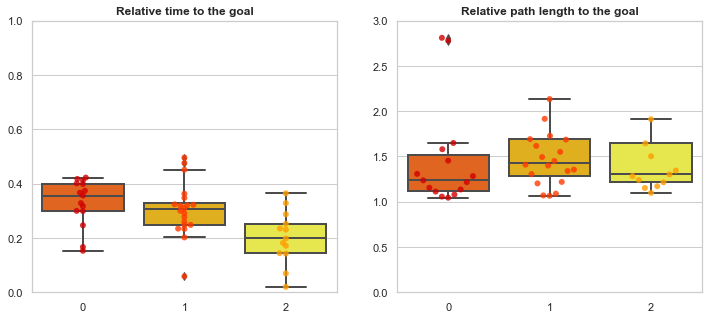

In [157]:
path_fig, path_axes = plt.subplots(1, 2, figsize=(12, 5))

categorical_plot(
    axes=path_axes[0],
    df=path_metrics_df,
    metric='rel_duration2goal',
    category='cluster',
    title='Relative time to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    lgd_labels=['Cluster 1', 'Cluster 2', 'Cluster 3'],
    kind='box',
    box_palette=box_pal,
    scatter_palette=scatter_pal,
)

categorical_plot(
    axes=path_axes[1],
    df=path_metrics_df,
    metric='rel_path_length2goal',
    category='cluster',
    title='Relative path length to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 3.0],
    lgd_labels=['Cluster 1', 'Cluster 2', 'Cluster 3'],
    kind='box',
    box_palette=box_pal,
    scatter_palette=scatter_pal,
)

plt.savefig("./pdf/all_shared_control_path_grouped_cluster.pdf", dpi=300)

plt.show()

In [158]:
plt.close()

#### Shared control metrics

In [159]:
control_metrics_df = eval_res_sorted_df[['seq', 'control_type'] + list(control_metrics) + ['cluster']]

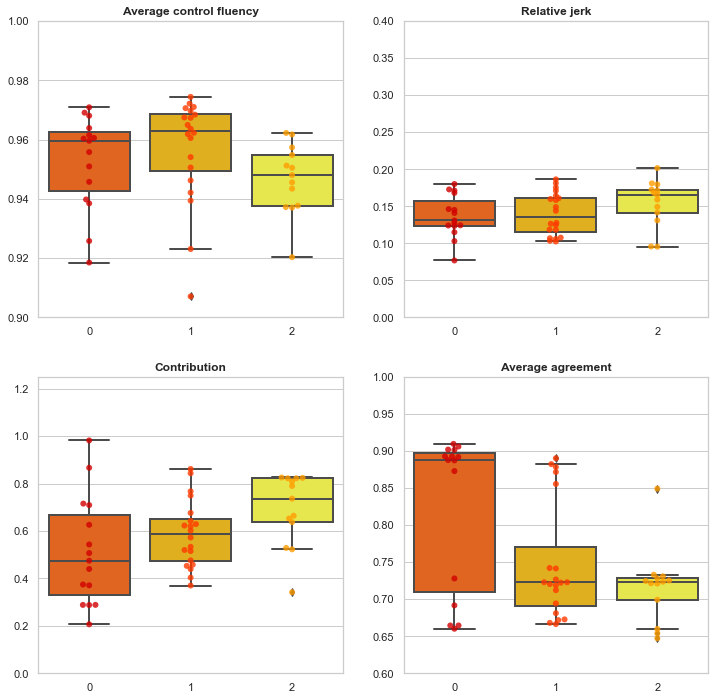

In [160]:
control_fig, control_axes = plt.subplots(2, 2, figsize=(12, 12))

categorical_plot(
    axes=control_axes[0,0],
    df=control_metrics_df,
    metric='avg_fluency',
    category='cluster',
    title='Average control fluency',
    xlabel='',
    ylabel='',
    ylim=[0.90, 1.0],
    lgd_labels=['Cluster 1', 'Cluster 2', 'Cluster 3'],
    kind='box',
    box_palette=box_pal,
    scatter_palette=scatter_pal,
)

categorical_plot(
    axes=control_axes[0,1],
    df=control_metrics_df,
    metric='rel_jerk',
    category='cluster',
    title='Relative jerk',
    xlabel='',
    ylabel='',
    ylim=[0, 0.4],
    lgd_labels=['Cluster 1', 'Cluster 2', 'Cluster 3'],
    kind='box',
    box_palette=box_pal,
    scatter_palette=scatter_pal,
)

categorical_plot(
    axes=control_axes[1,0],
    df=control_metrics_df,
    metric='contribution',
    category='cluster',
    title='Contribution',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.25],
    lgd_labels=['Cluster 1', 'Cluster 2', 'Cluster 3'],
    kind='box',
    box_palette=box_pal,
    scatter_palette=scatter_pal,
)

categorical_plot(
    axes=control_axes[1,1],
    df=control_metrics_df,
    metric='avg_agreement',
    category='cluster',
    title='Average agreement',
    xlabel='',
    ylabel='',
    ylim=[0.60, 1.0],
    lgd_labels=['Cluster 1', 'Cluster 2', 'Cluster 3'],
    kind='box',
    box_palette=box_pal,
    scatter_palette=scatter_pal,
)

plt.savefig("./pdf/all_shared_control_perf_grouped_cluster.pdf", dpi=300)

plt.show()

In [161]:
plt.close()

## one-way ANOVA test with different control methods

In [162]:
chosen_dates = ['0325', '0327', '0410', '0424', '1203']
chosen_type = ['mds', 'rds', 'shared_control']

eval_dirs = []

for root, dirs, files in walk(outbase, topdown=False, maxdepth=1):
    for dir_ in dirs:
        if any(s in dir_ for s in chosen_dates) and any(s in dir_ for s in chosen_type):
            dir_ = dir_.replace("_processed", "")
            eval_dirs.append(dir_)
            print("{}/ is available!".format(dir_))

0325_rds/ is available!
0325_shared_control/ is available!
0327_shared_control/ is available!
0410_mds/ is available!
0410_rds/ is available!
0410_shared_control/ is available!
0424_mds/ is available!
0424_rds/ is available!
0424_shared_control/ is available!
1203_shared_control/ is available!


In [163]:
eval_res_df = import_eval_res(eval_dirs)

Reading results from 0325_rds
Reading results from 0325_shared_control
Reading results from 0327_shared_control
Reading results from 0410_mds
Reading results from 0410_rds
Reading results from 0410_shared_control
Reading results from 0424_mds
Reading results from 0424_rds
Reading results from 0424_shared_control
Reading results from 1203_shared_control


### Mean-Std statistics

In [164]:
for ctrl in chosen_type:
    print(ctrl, ":", len(eval_res_df[eval_res_df.control_type == ctrl]))

frames_stat = []
for ctrl in chosen_type:
    eval_res_df_ = eval_res_df[eval_res_df.control_type == ctrl]
    stat_df = eval_res_df_.drop(['date'], axis=1).agg(['mean', 'std'])
    if ctrl == 'shared_control':
        stat_df.index = 'sc_'+stat_df.index.values
    else:
        stat_df.index = ctrl+'_'+stat_df.index.values
    frames_stat.append(stat_df)
    
stat_df_all = pd.concat(frames_stat) # , ignore_index=True
stat_df_all.index.name = 'Metrics'
stat_df_all

mds : 16
rds : 28
shared_control : 48


,avg_crowd_density2_5,std_crowd_density2_5,max_crowd_density2_5,avg_crowd_density5,std_crowd_density5,max_crowd_density5,avg_min_dist,virtual_collision,rel_duration2goal,rel_path_length2goal,path_length2goal,duration2goal,min_dist2goal,rel_jerk,avg_fluency,contribution,avg_agreement
Metrics,,,,,,,,,,,,,,,,,
mds_mean,0.115182,0.084864,0.452000,0.116808,0.049867,0.269768,1.189581,3.500000,0.282311,1.408097,21.563309,70.427876,4.743253,0.132651,0.972435,0.580148,0.711429
mds_std,0.028078,0.019079,0.080795,0.018398,0.009850,0.038680,0.158005,2.708013,0.092134,0.206072,5.917861,14.715994,4.045612,0.060549,0.016480,0.119643,0.060817
rds_mean,0.112300,0.081224,0.440177,0.107504,0.046952,0.257831,1.218439,5.428571,0.326802,1.288769,23.727457,65.308070,6.398355,0.087292,0.973170,0.892149,0.744372
rds_std,0.036586,0.019739,0.115319,0.036364,0.014353,0.065716,0.309439,7.166944,0.102856,0.190380,8.466883,21.221731,8.994769,0.037374,0.043637,0.080698,0.035521
sc_mean,0.169906,0.109615,0.596301,0.149881,0.062732,0.356772,1.077249,9.666667,0.284516,1.961518,34.630337,76.389545,5.001519,0.142802,0.952775,0.591899,0.763137
sc_std,0.076141,0.031913,0.174209,0.043876,0.016731,0.086375,0.297480,13.876865,0.106001,2.306204,11.741847,29.423999,5.266244,0.029735,0.015922,0.184929,0.091334


### ANOVA test

In [165]:
anova_metrics = (
    'rel_duration2goal',
    'rel_path_length2goal',
    'min_dist2goal',
    'avg_fluency',
    'contribution',
    'avg_agreement',
    'avg_crowd_density2_5',
    'max_crowd_density2_5',
    'avg_min_dist',
    'rel_jerk',
    'virtual_collision'
)

In [166]:
mds_anova_ = eval_res_df[eval_res_df.control_type=='mds']
mds_metrics = mds_anova_[list(anova_metrics)].values

rds_anova_ = eval_res_df[eval_res_df.control_type=='rds']
rds_metrics = rds_anova_[list(anova_metrics)].values

shared_control_anova_ = eval_res_df[eval_res_df.control_type=='shared_control']
shared_control_metrics = shared_control_anova_[list(anova_metrics)].values

In [167]:
fvalue12, pvalue12 = stats.f_oneway(mds_metrics, rds_metrics)
fvalue23, pvalue23 = stats.f_oneway(mds_metrics, shared_control_metrics)
fvalue13, pvalue13 = stats.f_oneway(rds_metrics, shared_control_metrics)
# total
fvalue, pvalue = stats.f_oneway(mds_metrics, rds_metrics, shared_control_metrics)

statP_df = pd.DataFrame(
    data=np.vstack((pvalue12, pvalue23, pvalue13, pvalue)), 
    index=['mds-rds', 'mds-shared', 'rds-shared', 'total'],
)
statP_df.columns = list(anova_metrics)
statP_df.index.name = 'Metrics'

statF_df = pd.DataFrame(
    data=np.vstack((fvalue12, fvalue23, fvalue13, fvalue)), 
    index=['mds-rds', 'mds-shared', 'rds-shared', 'total'],
)
statF_df.columns = list(anova_metrics)
statF_df.index.name = 'Metrics'

In [168]:
statP_df

,rel_duration2goal,rel_path_length2goal,min_dist2goal,avg_fluency,contribution,avg_agreement,avg_crowd_density2_5,max_crowd_density2_5,avg_min_dist,rel_jerk,virtual_collision
Metrics,,,,,,,,,,,
mds-rds,0.159630,0.058940,0.491302,0.948874,4.290310e-13,0.027973,0.786906,0.719410,0.730420,3.636343e-03,0.308525
mds-shared,0.941028,0.344015,0.858528,0.000075,8.130869e-01,0.039059,0.006815,0.002246,0.155176,3.763340e-01,0.083784
rds-shared,0.094132,0.128738,0.394981,0.004481,7.232160e-12,0.301793,0.000347,0.000067,0.052969,5.567170e-10,0.137700
total,0.189842,0.200956,0.604996,0.003166,4.224340e-13,0.053537,0.000102,0.000016,0.087489,1.877481e-07,0.085962


In [169]:
statF_df

,rel_duration2goal,rel_path_length2goal,min_dist2goal,avg_fluency,contribution,avg_agreement,avg_crowd_density2_5,max_crowd_density2_5,avg_min_dist,rel_jerk,virtual_collision
Metrics,,,,,,,,,,,
mds-rds,2.049764,3.769008,0.482086,0.004161,106.590363,5.182690,0.074019,0.130807,0.120319,9.490492,1.062590
mds-shared,0.005517,0.909255,0.032038,17.986272,0.056385,4.444682,7.836970,10.163357,2.070758,0.794014,3.088494
rds-shared,2.875657,2.360115,0.732051,8.595673,66.159206,1.081299,14.070918,17.865163,3.867881,50.869134,2.251963
total,1.692973,1.633951,0.505381,6.144041,39.917570,3.025819,10.209318,12.536624,2.504166,18.525401,2.522770


In [170]:
# print(statF_df.T.to_latex())
# print(statP_df.T.to_latex())
# print(stat_df_all.T.to_latex())